# 0. Dependencies and Data

In [1]:
# Load revelant packages
import requests
import os
from os import path
import csv
import random
import numpy as np
import pandas as pd
import time
import re
import json
from sentence_transformers.readers import InputExample
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import torch
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Load the data
with open('/content/drive/MyDrive/DLSS Project/genius_cleaned_merged.json', "r") as f:
    data = json.load(f)

df_full = pd.DataFrame(data)

# ?rocess release date + create 'year' column
df_full['release_date'] = pd.to_datetime(df_full['release_date'], errors='coerce')
df_full['year'] = df_full['release_date'].dt.year

# Keep columns necessary for current task
columns_to_keep = ["lyrics_clean"]
df = df_full[columns_to_keep].copy()

# Drop rows with missing values
df = df.dropna().reset_index(drop=True)

In [10]:
print(len(df['lyrics_clean']))

3195


Generate embeddings of the songs:

In [11]:
# Load the embedding model
model = SentenceTransformer("/content/drive/MyDrive/final")

In [12]:
# Use encode function on the 'lyrics_clean' column.
embeddings = model.encode(df['lyrics_clean'].tolist(), show_progress_bar=True, convert_to_numpy=True)

# Shape = (number of lyrics (text of one whole song), number of dimensions in each embedding).
print(f"Embeddings created successfully with shape: {embeddings.shape}")

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Embeddings created successfully with shape: (3195, 384)


In [13]:
norms = np.linalg.norm(embeddings, axis=1)
print(norms[:10])  # look at first 10 norms
print("Mean norm:", norms.mean())

[0.99999994 1.         0.99999994 0.99999994 1.         0.99999994
 1.         1.         1.         1.        ]
Mean norm: 1.0


In [14]:
print(type(embeddings))
print(embeddings.shape)
print(len(embeddings))

<class 'numpy.ndarray'>
(3195, 384)
3195


In [15]:
df["embedding"] = list(embeddings)
print(len(df))

df.head()

3195


,lyrics_clean,embedding
0,want lot christmas one thing need care present...,"[-0.044458214, 0.024449673, -0.010196912, -0.0..."
1,bye bye bye doin tonight probably gonna start ...,"[-0.07438091, -0.04296196, 0.07234897, 0.03948..."
2,gon make lose mind gon make go gon make act fo...,"[0.023626128, -0.0743276, -0.08688256, -0.1002..."
3,look one shot one opportunity seize everything...,"[0.05967509, -0.00063140615, 0.00999931, -0.04..."
4,arf arf get twisted rap shit mine motherfucker...,"[0.03751592, -0.0789732, -0.07142526, -0.11179..."


In [17]:
#df.to_csv('/content/drive/MyDrive/df_embeddings.csv', index=False)

In [15]:
#df = pd.read_csv('/content/drive/MyDrive/df_embeddings.csv')
#df.head()

,lyrics_clean,embedding
0,want lot christmas one thing need care present...,[-4.44582142e-02 2.44496725e-02 -1.01969121e-...
1,bye bye bye doin tonight probably gonna start ...,[-7.43809119e-02 -4.29619588e-02 7.23489672e-...
2,gon make lose mind gon make go gon make act fo...,[ 2.36261282e-02 -7.43276030e-02 -8.68825614e-...
3,look one shot one opportunity seize everything...,[ 5.96750900e-02 -6.31406147e-04 9.99930967e-...
4,arf arf get twisted rap shit mine motherfucker...,[ 3.75159197e-02 -7.89731964e-02 -7.14252591e-...


Load the dataset from EDA containing additional information on songs and add the emebeddings to their respective songs:

In [4]:
df_eda = pd.read_csv('/content/drive/MyDrive/EDA_df.csv')

In [8]:
df_eda[df_eda['artist'] == 'Taylor Swift']['release_date'].unique()

array(['2017-08-25', '2017-09-03', '2017-11-10', '2019-06-14',
       '2019-07-23', '2019-08-16', '2019-08-23', '2019-12-06',
       '2020-01-31', '2020-07-24', '2020-12-11', '2021-02-12',
       '2021-04-07', '2021-04-09', '2021-09-17', '2021-11-12',
       '2021-11-22', '2022-05-06', '2022-06-24', '2022-10-21',
       '2023-03-17', '2023-07-07', '2014-10-27', '2023-10-27',
       '2023-05-26', '2024-04-19'], dtype=object)

In [3]:
# Load the data

df_eda = pd.read_csv('/content/drive/MyDrive/EDA_df.csv')
print(len(df_eda))

# Remove columns that are not necessary
df_eda = df_eda.drop(columns=['genius_id', 'tags', 'rank', 'peak', 'peak_date', 'tokens'])

print(len(df_eda))
df_eda.head()

26636
26636


,title,artist,primary_tag,release_date,album,lyrics_clean,chart_date,year,month,month_ts,topic,topic_name
0,All I Want For Christmas Is You,Mariah Carey,r&b,1994-10-29,Greatest Hits,want lot christmas one thing need care present...,2018-01-06,2018,2018-01,2018-01-01,6,Love & Devotion
1,The Christmas Song (Merry Christmas To You),"Nat ""King"" Cole",pop,NaN,The Complete Capitol Recordings of The Nat Kin...,chestnuts roasting open fire jack frost nippin...,2018-01-06,2018,2018-01,2018-01-01,1,Romantic Struggles
2,The Weekend,SZA,r&b,2017-09-26,Ctrl (Deluxe),mood right mood say got girl want want got gir...,2018-01-06,2018,2018-01,2018-01-01,6,Love & Devotion
3,No Smoke,YoungBoy Never Broke Again,rap,2017-08-03,AI YoungBoy,dj chose bro bro nigga homie count money fuck ...,2018-01-06,2018,2018-01,2018-01-01,3,Rap/Hip-Hop
4,New Rules,Dua Lipa,electronic,2017-06-02,Dua Lipa (Japan Special Edition),one talkin sleep night makin crazy wrote read ...,2018-01-06,2018,2018-01,2018-01-01,1,Romantic Struggles


In [16]:
# Merge embeddings based on the cleaned song lyrics
df_dis = pd.merge(df_eda, df.drop_duplicates(subset='lyrics_clean'), on='lyrics_clean', how='left')
print(len(df_dis))
df_dis.head()

26636


,title,artist,genius_id,primary_tag,tags,release_date,album,lyrics_clean,chart_date,rank,peak,peak_date,year,month,month_ts,tokens,topic,topic_name,embedding
0,All I Want For Christmas Is You,Mariah Carey,204233,r&b,"['R&B', 'Pop', 'USA', 'In English', 'Soul Pop'...",1994-10-29,Greatest Hits,want lot christmas one thing need care present...,2018-01-06,13,1.0,2019-12-21,2018,2018-01,2018-01-01,"['lot', 'christmas', 'care', 'present', 'under...",6,Love & Devotion,"[-0.044458214, 0.024449673, -0.010196912, -0.0..."
1,The Christmas Song (Merry Christmas To You),"Nat ""King"" Cole",1717793,pop,"['Pop', 'Big Band', 'Swing', 'Jazz', 'Acoustic...",NaN,The Complete Capitol Recordings of The Nat Kin...,chestnuts roasting open fire jack frost nippin...,2018-01-06,42,9.0,2023-01-07,2018,2018-01,2018-01-01,"['chestnut', 'roasting', 'open', 'fire', 'jack...",1,Romantic Struggles,"[0.020783577, 0.09585588, 0.12284183, 0.053424..."
2,The Weekend,SZA,3113598,r&b,"['R&B', 'USA', 'In English', 'Psychedelic Soul...",2017-09-26,Ctrl (Deluxe),mood right mood say got girl want want got gir...,2018-01-06,33,NaN,NaN,2018,2018-01,2018-01-01,"['mood', 'mood', 'girl', 'girl', 'feelin', 're...",6,Love & Devotion,"[-0.08247718, -0.04694236, 0.117958926, 0.0694..."
3,No Smoke,YoungBoy Never Broke Again,3183597,rap,"['Rap', 'Dirty South', 'Trap']",2017-08-03,AI YoungBoy,dj chose bro bro nigga homie count money fuck ...,2018-01-06,77,61.0,2018-02-03,2018,2018-01,2018-01-01,"['chose', 'bro', 'bro', 'nigga', 'homie', 'cou...",3,Rap/Hip-Hop,"[0.06290257, -0.030899374, -0.074903406, -0.14..."
4,New Rules,Dua Lipa,3013669,electronic,"['Electronic', 'Pop', 'EDM', 'In English', 'UK...",2017-06-02,Dua Lipa (Japan Special Edition),one talkin sleep night makin crazy wrote read ...,2018-01-06,12,6.0,2018-02-17,2018,2018-01,2018-01-01,"['talkin', 'sleep', 'night', 'makin', 'crazy',...",1,Romantic Struggles,"[-0.068854064, 0.0020879416, 0.062143132, 0.07..."


# 1. Analysing Distances between emebddings

In [21]:
# Convert emebeddings to numpy array and stack emeddings into a single matrix for computation
df_dis["embedding"] = df_dis["embedding"].apply(lambda x: np.array(x))
X = np.vstack(df_dis["embedding"].values)

# compute cosine similarities between consecutive rows (songs)
similarities = [
    cosine_similarity([X[i]], [X[i+1]])[0][0]
    for i in range(len(X)-1)]

# store results in df
df_dis["similarity_to_next"] = similarities + [np.nan]
df_dis.head()

,title,artist,primary_tag,release_date,album,lyrics_clean,chart_date,year,month,month_ts,topic,topic_name,embedding,similarity_to_next
0,All I Want For Christmas Is You,Mariah Carey,r&b,1994-10-29,Greatest Hits,want lot christmas one thing need care present...,2018-01-06,2018,2018-01,2018-01-01,6,Love & Devotion,"[-0.044458214, 0.024449673, -0.010196912, -0.0...",0.589797
1,The Christmas Song (Merry Christmas To You),"Nat ""King"" Cole",pop,NaN,The Complete Capitol Recordings of The Nat Kin...,chestnuts roasting open fire jack frost nippin...,2018-01-06,2018,2018-01,2018-01-01,1,Romantic Struggles,"[0.020783577, 0.09585588, 0.12284183, 0.053424...",0.320254
2,The Weekend,SZA,r&b,2017-09-26,Ctrl (Deluxe),mood right mood say got girl want want got gir...,2018-01-06,2018,2018-01,2018-01-01,6,Love & Devotion,"[-0.08247718, -0.04694236, 0.117958926, 0.0694...",-0.328601
3,No Smoke,YoungBoy Never Broke Again,rap,2017-08-03,AI YoungBoy,dj chose bro bro nigga homie count money fuck ...,2018-01-06,2018,2018-01,2018-01-01,3,Rap/Hip-Hop,"[0.06290257, -0.030899374, -0.074903406, -0.14...",-0.405894
4,New Rules,Dua Lipa,electronic,2017-06-02,Dua Lipa (Japan Special Edition),one talkin sleep night makin crazy wrote read ...,2018-01-06,2018,2018-01,2018-01-01,1,Romantic Struggles,"[-0.068854064, 0.0020879416, 0.062143132, 0.07...",0.200746


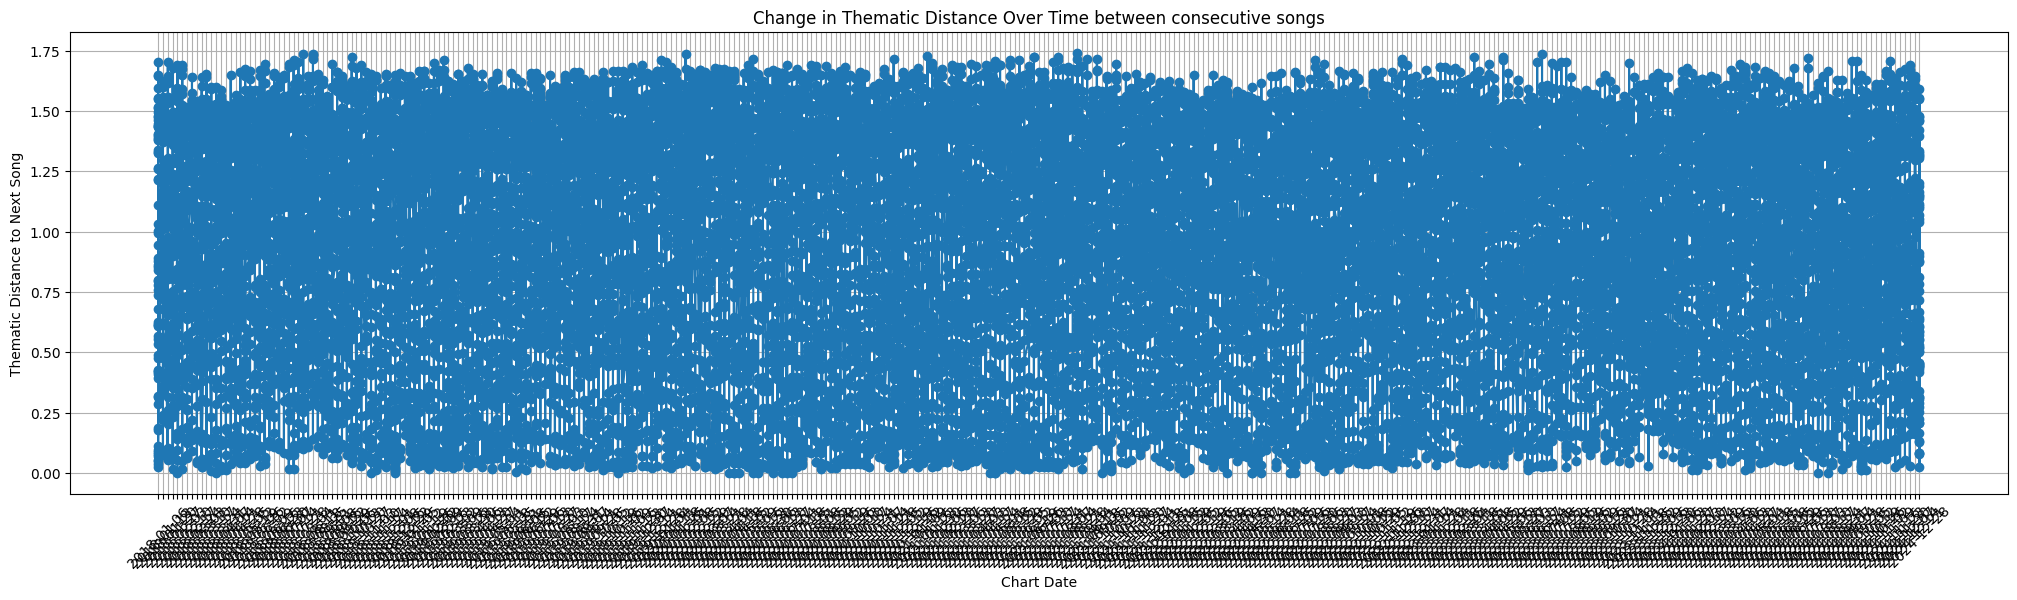

In [22]:
# Compute distance to the next song (based on similarity)
df_dis["distance_to_next"] = 1 - df_dis["similarity_to_next"]

# Plot how the distance between songs changed over time (from one song to the next)
plt.figure(figsize=(25, 6))
plt.plot(df_dis["chart_date"], df_dis["distance_to_next"], marker='o', linestyle='-')
plt.xlabel("Chart Date")
plt.ylabel("Thematic Distance to Next Song")
plt.xticks(rotation=45)
plt.title("Change in Thematic Distance Over Time between consecutive songs")
plt.grid(True)
plt.show()

Interpreation: This plot illustrates the thematic distance between the embeddings of consecutive songs. While it serves an exploratory purpose by visualizing potential shifts in theme over time, the measure is not directly interpretable in a meaningful way.

# 2. Artist Trajectory Analysis

During the exploratory phase of the artist trajectory analysis we decided to focus on the top ten most successful artist during our observation period (Success was measured by how often an artist appeared in within the weekly top 100 from 2018 to 2024)

Analysis of the theme coherence of albums:

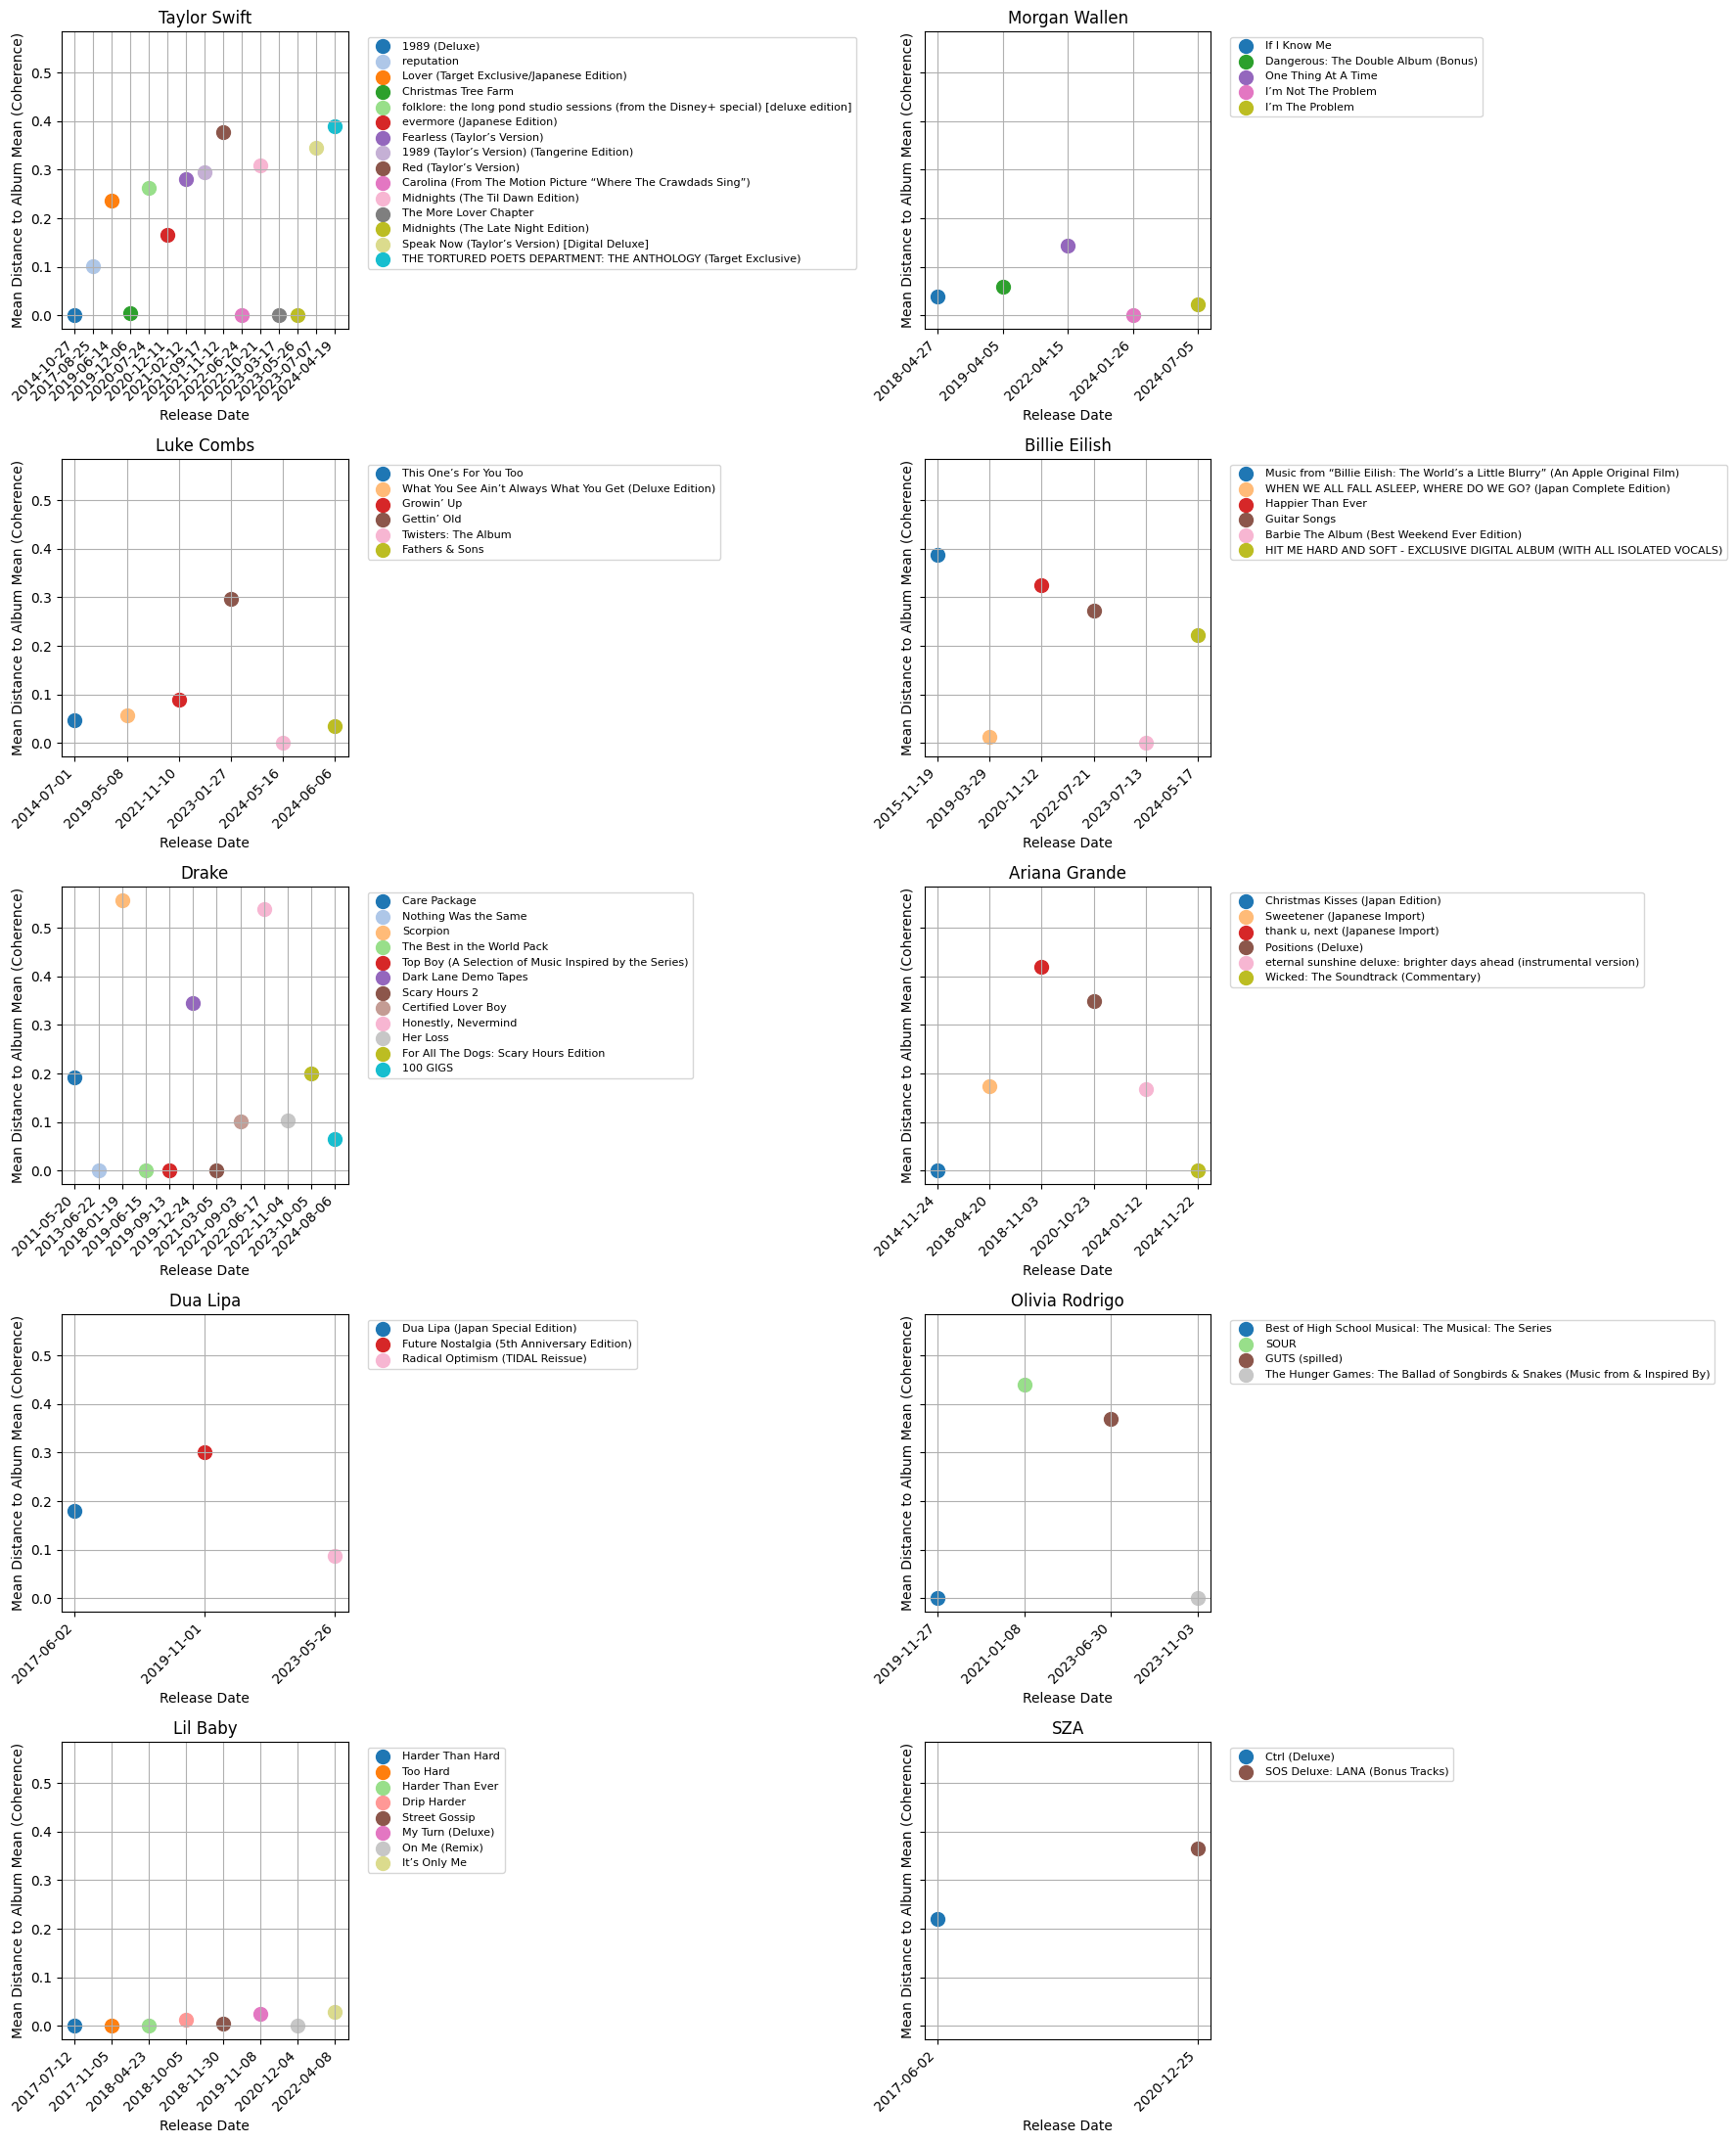

In [17]:
# Retrieve the top 10 artists
top_artists = df_dis["artist"].value_counts().head(10).index.tolist()

# Set up visualization
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 22), sharey=True)
axes = axes.flatten()

for i, artist in enumerate(top_artists):
    df_artist = df_dis[df_dis["artist"] == artist].sort_values("release_date")

    album_stats = []

    # Loop over all the albums of an artist
    for album in df_artist["album"].unique():
        df_album = df_artist[df_artist["album"] == album].dropna(subset=["embedding"])
        if df_album.empty:
            continue

        # Compute album mean embedding
        album_mean = np.mean(np.stack(df_album["embedding"].values), axis=0)

        # Distances of songs to the album mean (spread)
        distances = [
            1 - np.dot(album_mean, emb) / (np.linalg.norm(album_mean) * np.linalg.norm(emb))
            for emb in df_album["embedding"]
        ]

        album_stats.append({
            "album": album,
            "release_date": df_album["release_date"].min(),
            "spread": np.mean(distances)})

    df_album_stats = pd.DataFrame(album_stats).sort_values("release_date")

    # Set distinct colors per album
    albums = df_album_stats["album"].tolist()
    colors = [cm.tab20(j / len(albums)) for j in range(len(albums))]
    album_color_map = {album: color for album, color in zip(albums, colors)}

    # Scatter plot (spread over time)
    for idx, row in df_album_stats.iterrows():
        axes[i].scatter(row["release_date"], row["spread"],
                        color=album_color_map[row["album"]], s=100, label=row["album"])

    axes[i].set_title(artist)
    axes[i].set_xlabel("Release Date")
    axes[i].set_ylabel("Mean Distance to Album Mean (Coherence)")
    axes[i].grid(True)

    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

    # Create legend
    handles, labels = axes[i].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[i].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

Interpretation:
These plots illustrate how thematically cohesive the songs of an album are within the embedding space. Lower values indicate that songs cluster closely around the album’s overall “center” (mean embedding), suggesting stronger thematic coherence, while higher values indicate greater spread and stylistic diversity within the album. The measure is computed by taking the distance between each song’s embedding and the album’s mean embedding, and then averaging these distances.

Limitations:
The analysis only includes songs from each album that entered the Top 100 for at least one week between 2018 and 2024, which may not fully represent the album’s complete content. Additionally, some albums or releases are represented by a single charting song. In such cases, the spread score is trivially low, reflecting dataset sparsity rather than genuine thematic coherence.

Analysis of the similarity between albums of the top artists:

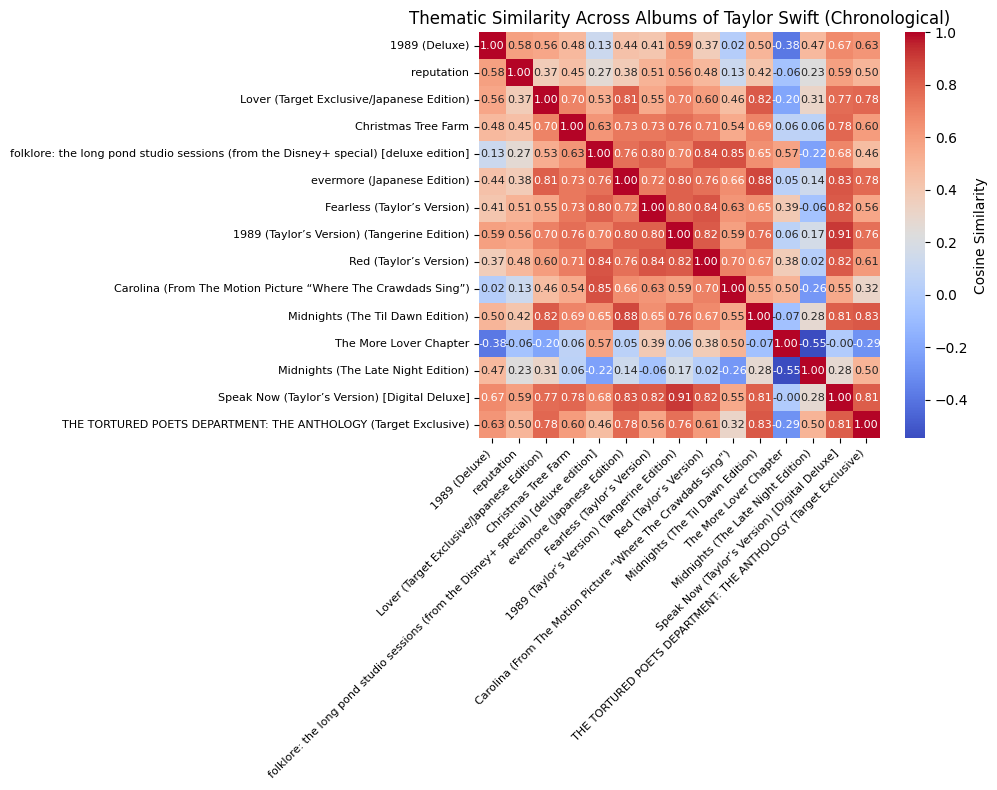

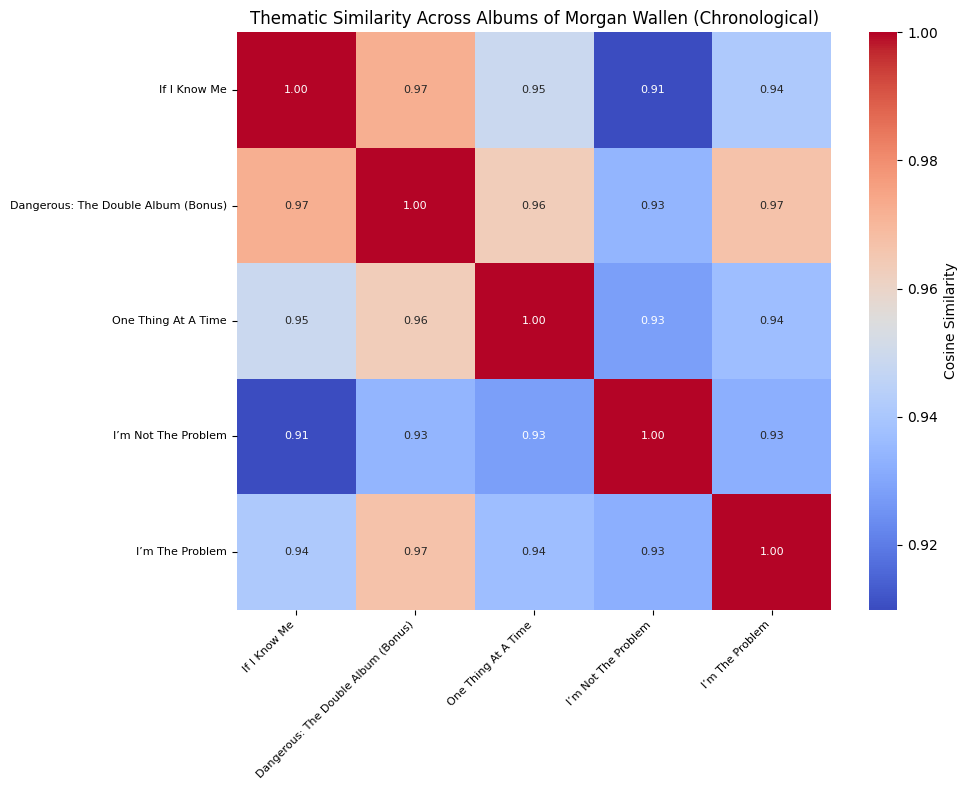

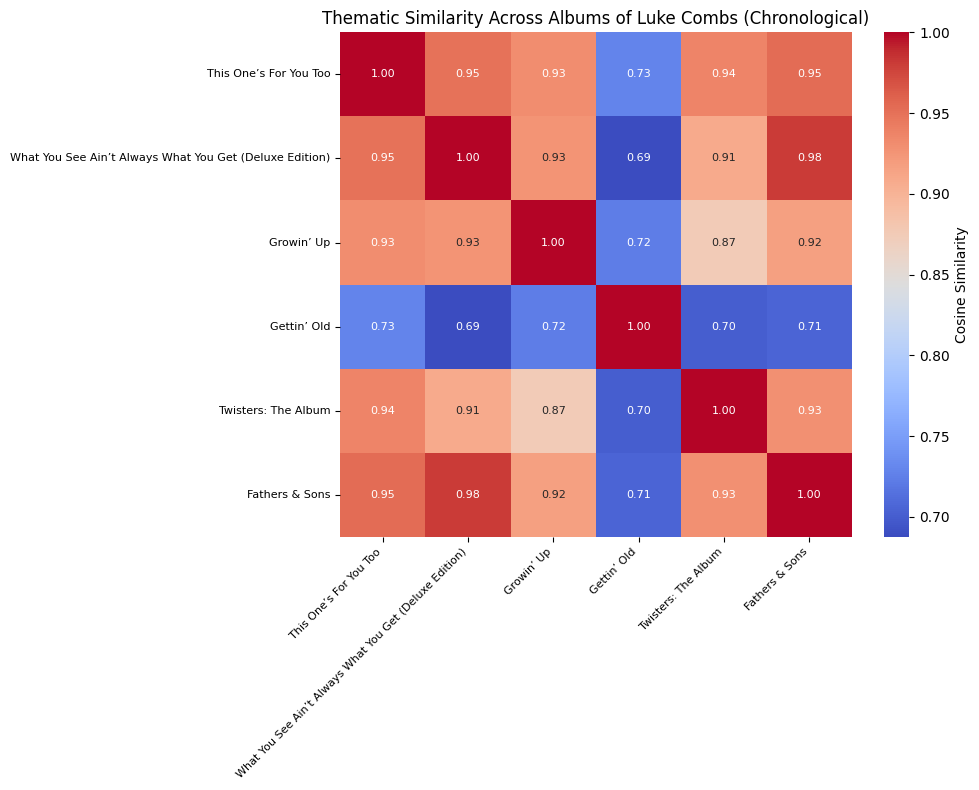

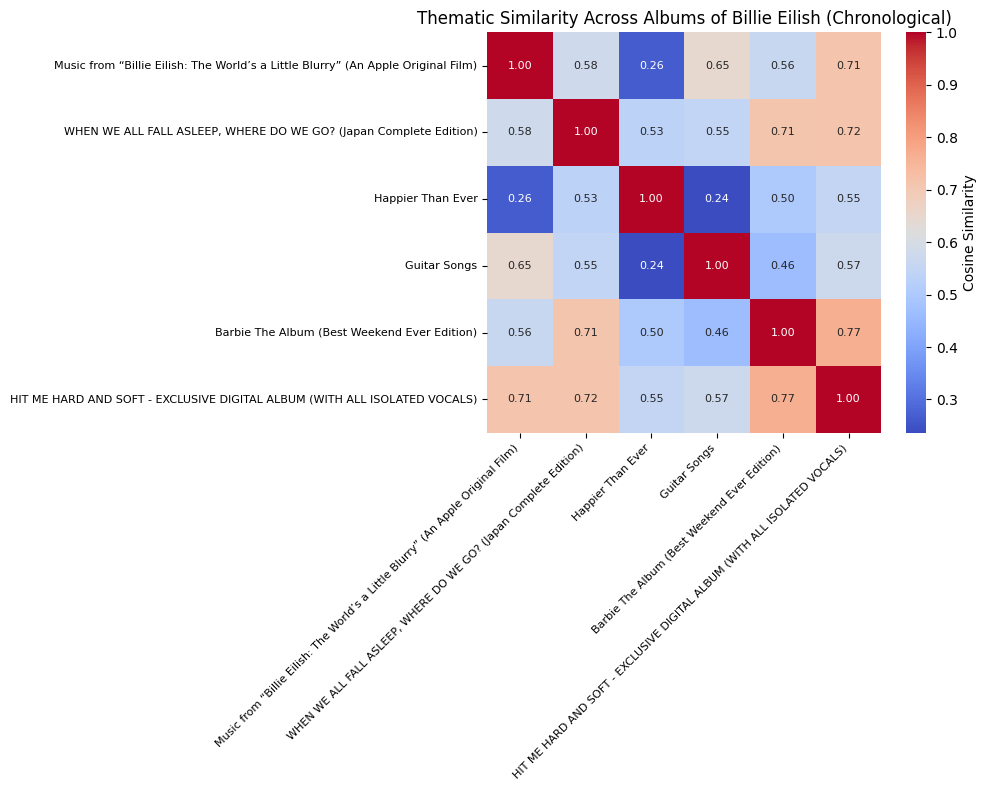

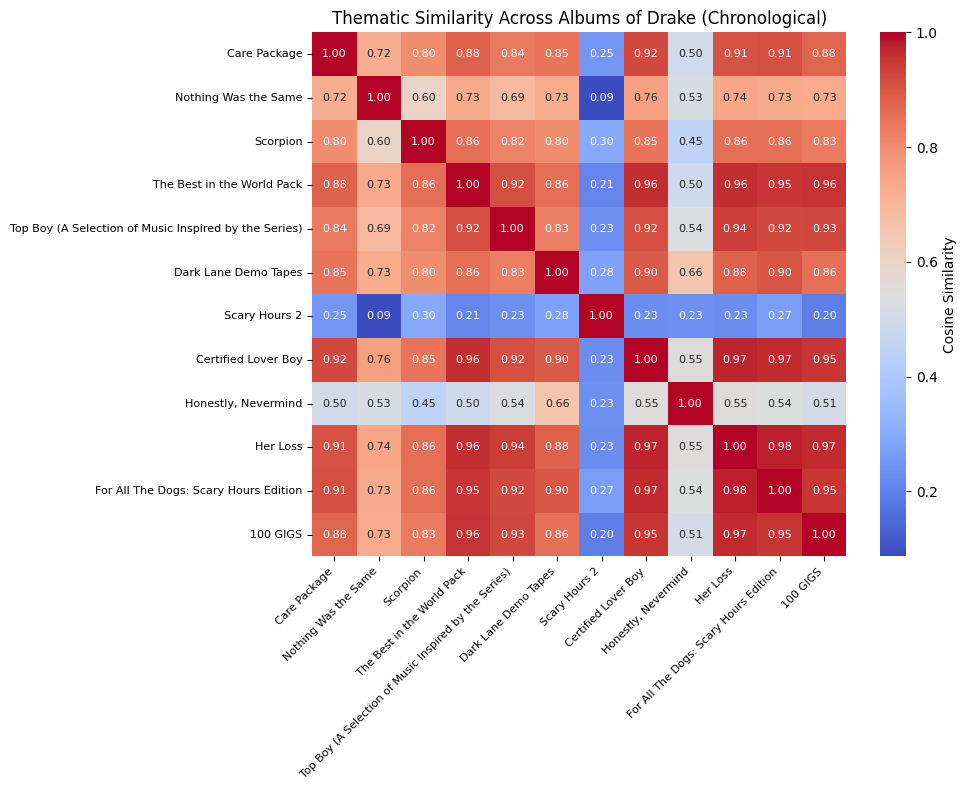

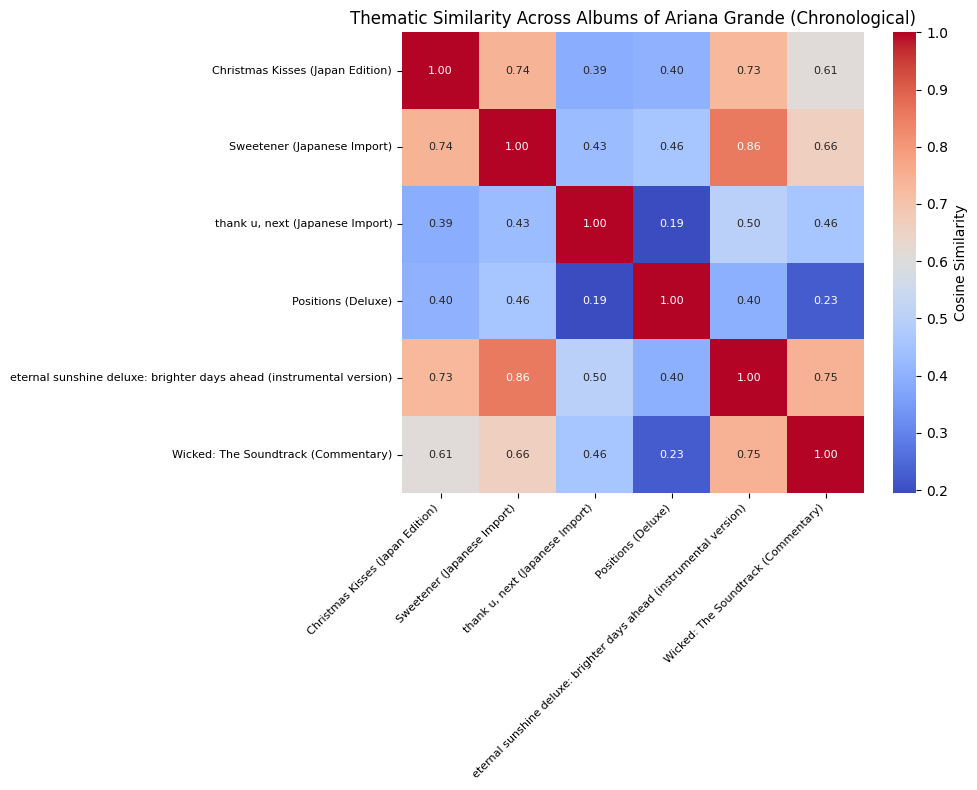

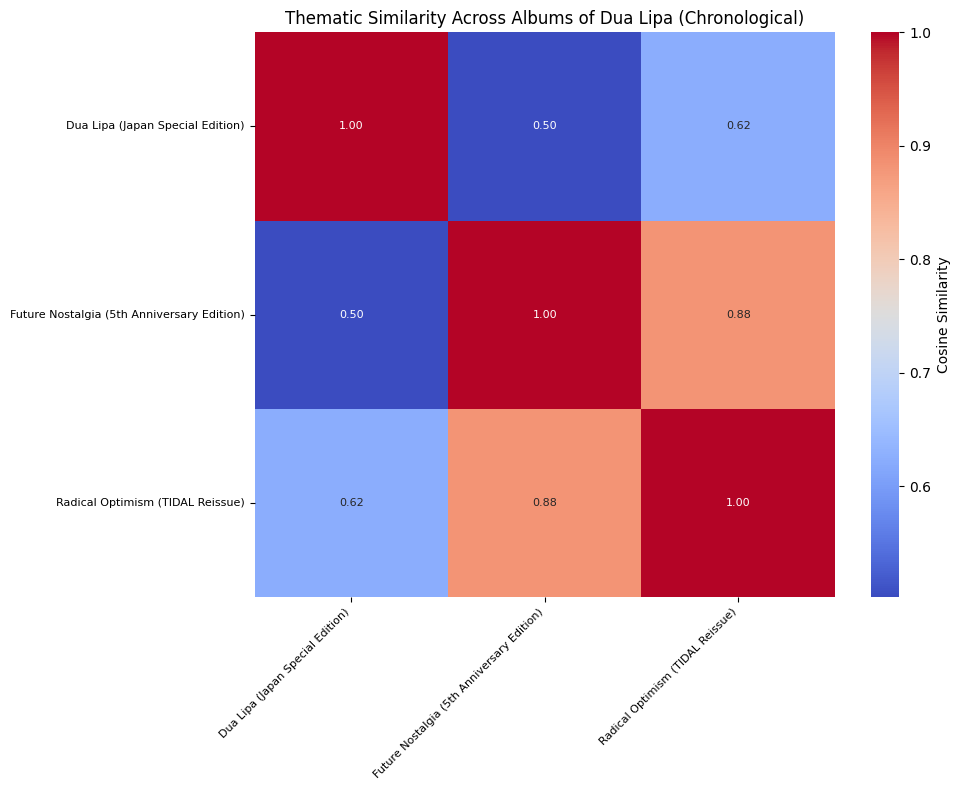

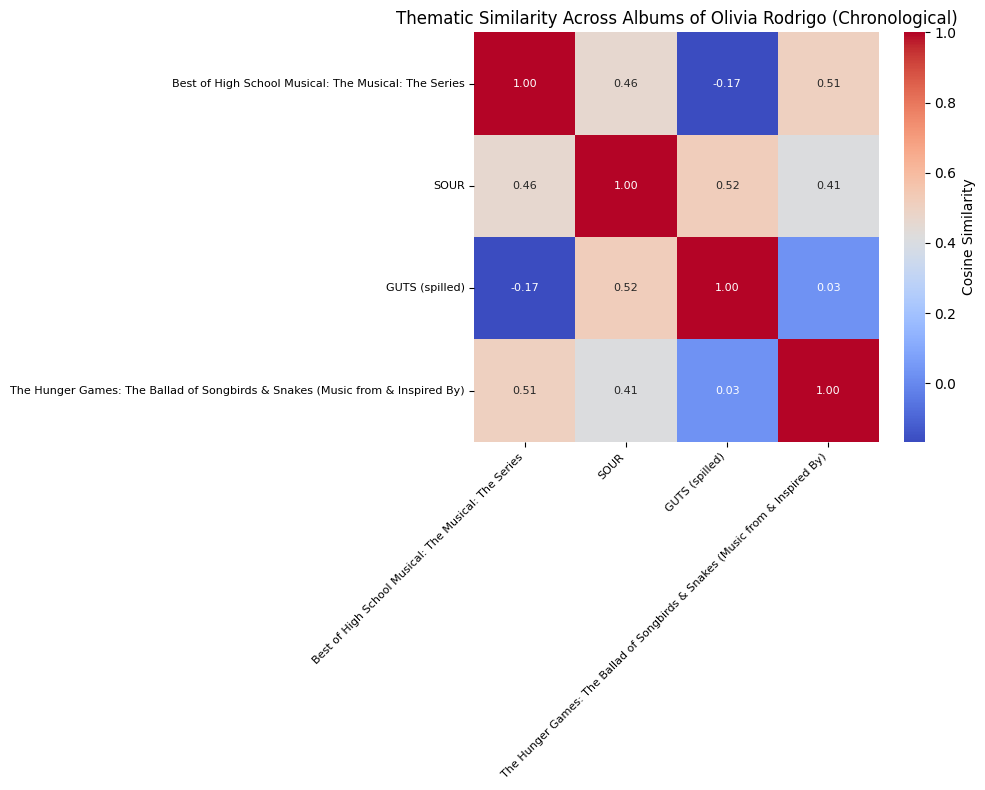

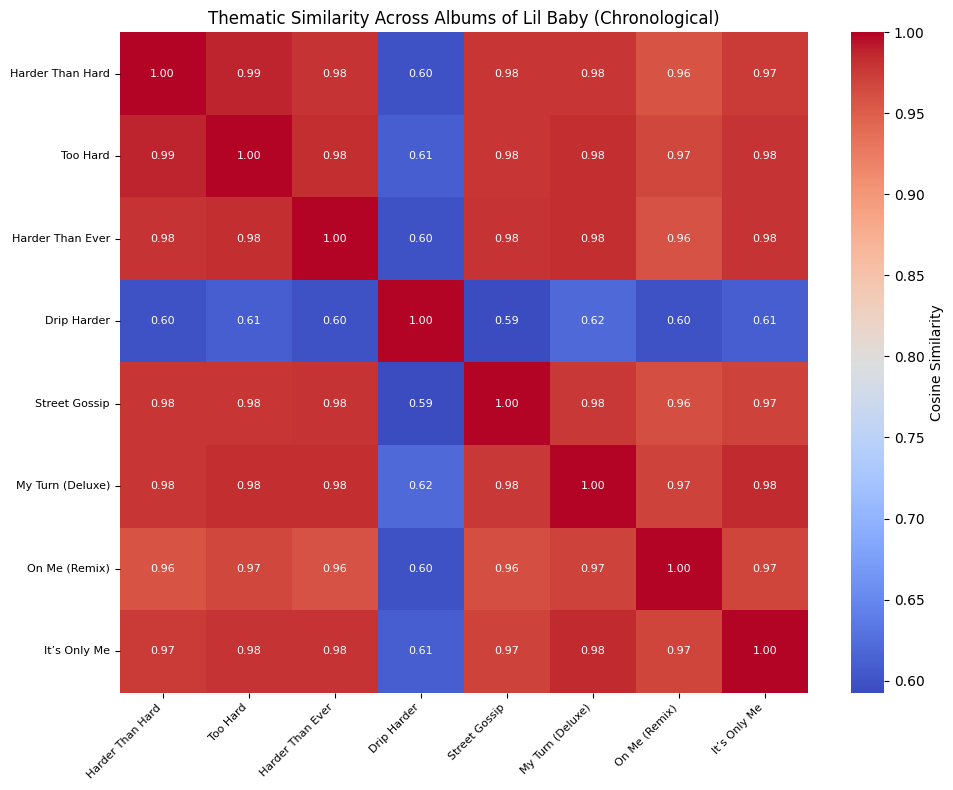

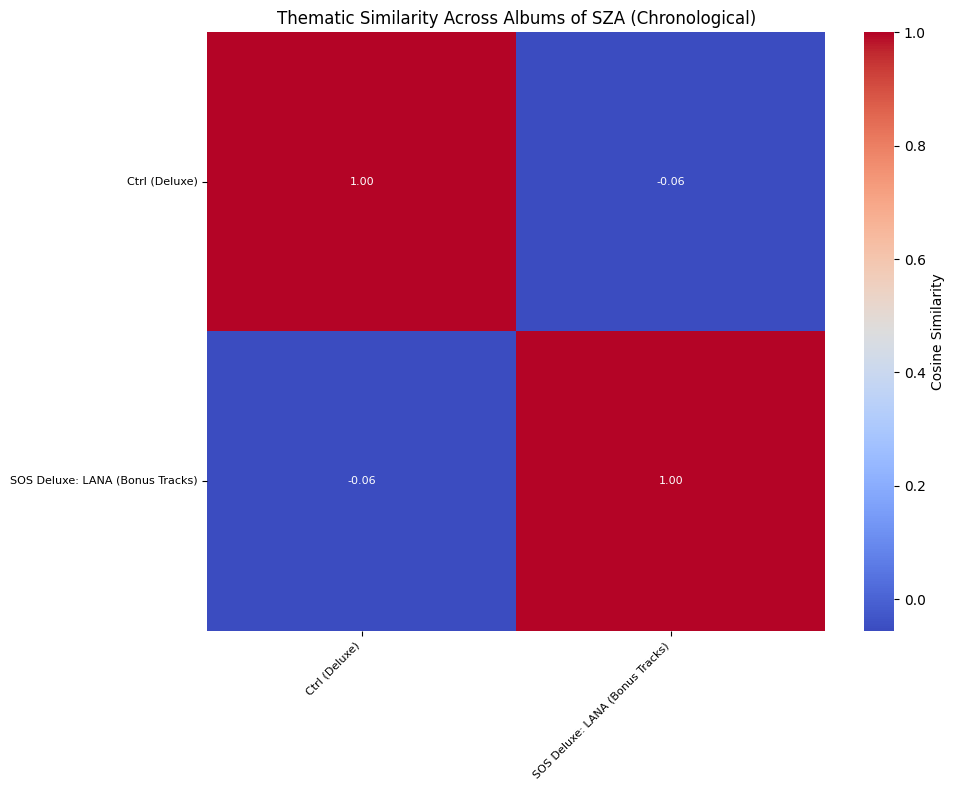

In [26]:
# Retrieve top 10 artists
top_artists = df_dis["artist"].value_counts().head(10).index.tolist()

# Create a dataframe for each arist, where song are ordered by release date
for artist in top_artists:
    df_artist = df_dis[df_dis["artist"] == artist].sort_values("release_date")

    # Compute mean embedding per album and album date
    album_embeddings = {}
    album_dates = {}

    for album in df_artist["album"].unique():
        df_album = df_artist[df_artist["album"] == album].dropna(subset=["embedding"])
        if df_album.empty:
            continue
        mean_emb = np.mean(np.stack(df_album["embedding"].values), axis=0)
        album_embeddings[album] = mean_emb
        album_dates[album] = df_album["release_date"].min()  # first song date

    if len(album_embeddings) < 2:
        continue  # skip if less than 2 albums (comparison not possible)

    # Sort albums by release date
    albums_sorted = sorted(album_embeddings.keys(), key=lambda x: album_dates[x])
    emb_matrix = np.stack([album_embeddings[a] for a in albums_sorted])

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(emb_matrix)
    df_similarity = pd.DataFrame(similarity_matrix, index=albums_sorted, columns=albums_sorted)

    # Plot heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(df_similarity, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Cosine Similarity'}, annot_kws={"fontsize": 8})
    plt.title(f"Thematic Similarity Across Albums of {artist} (Chronological)")
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()


Interpretation:
Each heatmap shows how thematically similar an artist’s albums are to one another in the embedding space. Darker/redder cells (higher cosine similarity, close to 1) indicate albums that are more similar in lyrical content or themes, while lighter/bluer cells (lower values) indicate albums that diverge more strongly. The diagonal is always 1, since an album is perfectly similar to itself. By looking across rows/columns in chronological order (y-axis from top to bottom, x-axis from left to right, starting with the earliest release), you can see whether the artist’s style stays consistent over time or shifts significantly between albums. High similarity values along the diagonal indicate consistent themes across consecutive albums, while lower similarity values off-diagonal suggest periods of experimentation or thematic change.

Limitations:
Only songs that entered the Top 100 between 2018 and 2024 are included. This means the album-level averages may not fully capture the thematic diversity of the original album. Albums represented by very few songs may also give unstable or misleading similarity values.

Analysis of the similarity between popular songs of the top artists:

In [19]:
# Add a column capturing release year
df_dis['release_date'] = pd.to_datetime(df_dis['release_date'])
df_dis['release_year'] = df_dis['release_date'].dt.year
df_dis.head()

,title,artist,genius_id,primary_tag,tags,release_date,album,lyrics_clean,chart_date,rank,peak,peak_date,year,month,month_ts,tokens,topic,topic_name,embedding,release_year
0,All I Want For Christmas Is You,Mariah Carey,204233,r&b,"['R&B', 'Pop', 'USA', 'In English', 'Soul Pop'...",1994-10-29,Greatest Hits,want lot christmas one thing need care present...,2018-01-06,13,1.0,2019-12-21,2018,2018-01,2018-01-01,"['lot', 'christmas', 'care', 'present', 'under...",6,Love & Devotion,"[-0.044458214, 0.024449673, -0.010196912, -0.0...",1994.0
1,The Christmas Song (Merry Christmas To You),"Nat ""King"" Cole",1717793,pop,"['Pop', 'Big Band', 'Swing', 'Jazz', 'Acoustic...",NaT,The Complete Capitol Recordings of The Nat Kin...,chestnuts roasting open fire jack frost nippin...,2018-01-06,42,9.0,2023-01-07,2018,2018-01,2018-01-01,"['chestnut', 'roasting', 'open', 'fire', 'jack...",1,Romantic Struggles,"[0.020783577, 0.09585588, 0.12284183, 0.053424...",NaN
2,The Weekend,SZA,3113598,r&b,"['R&B', 'USA', 'In English', 'Psychedelic Soul...",2017-09-26,Ctrl (Deluxe),mood right mood say got girl want want got gir...,2018-01-06,33,NaN,NaN,2018,2018-01,2018-01-01,"['mood', 'mood', 'girl', 'girl', 'feelin', 're...",6,Love & Devotion,"[-0.08247718, -0.04694236, 0.117958926, 0.0694...",2017.0
3,No Smoke,YoungBoy Never Broke Again,3183597,rap,"['Rap', 'Dirty South', 'Trap']",2017-08-03,AI YoungBoy,dj chose bro bro nigga homie count money fuck ...,2018-01-06,77,61.0,2018-02-03,2018,2018-01,2018-01-01,"['chose', 'bro', 'bro', 'nigga', 'homie', 'cou...",3,Rap/Hip-Hop,"[0.06290257, -0.030899374, -0.074903406, -0.14...",2017.0
4,New Rules,Dua Lipa,3013669,electronic,"['Electronic', 'Pop', 'EDM', 'In English', 'UK...",2017-06-02,Dua Lipa (Japan Special Edition),one talkin sleep night makin crazy wrote read ...,2018-01-06,12,6.0,2018-02-17,2018,2018-01,2018-01-01,"['talkin', 'sleep', 'night', 'makin', 'crazy',...",1,Romantic Struggles,"[-0.068854064, 0.0020879416, 0.062143132, 0.07...",2017.0


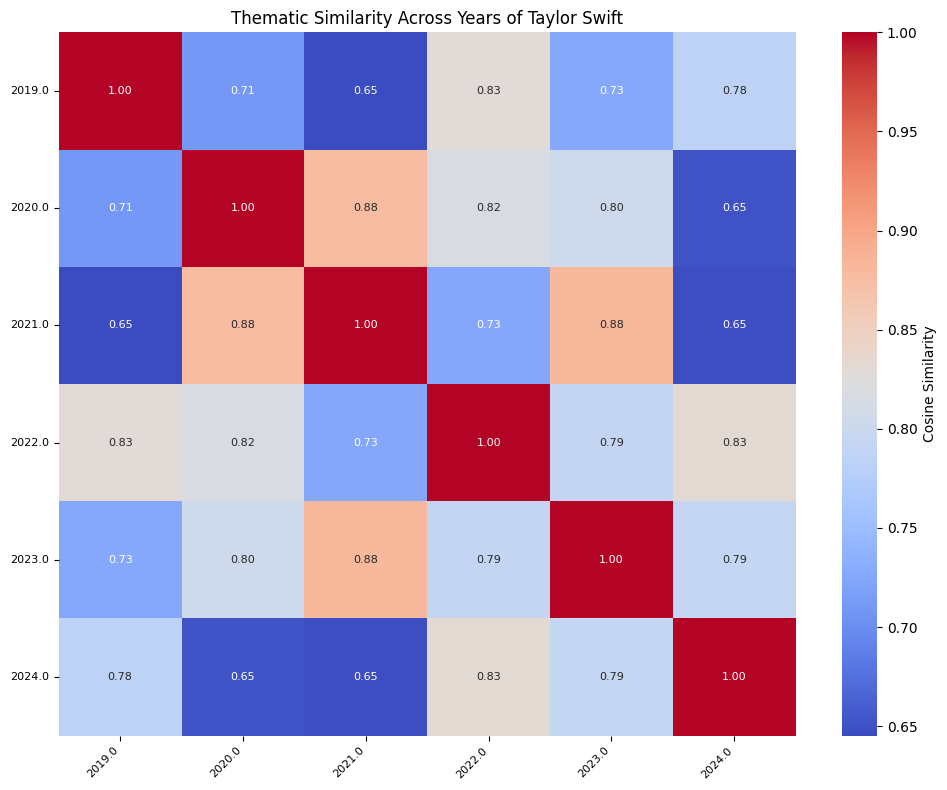

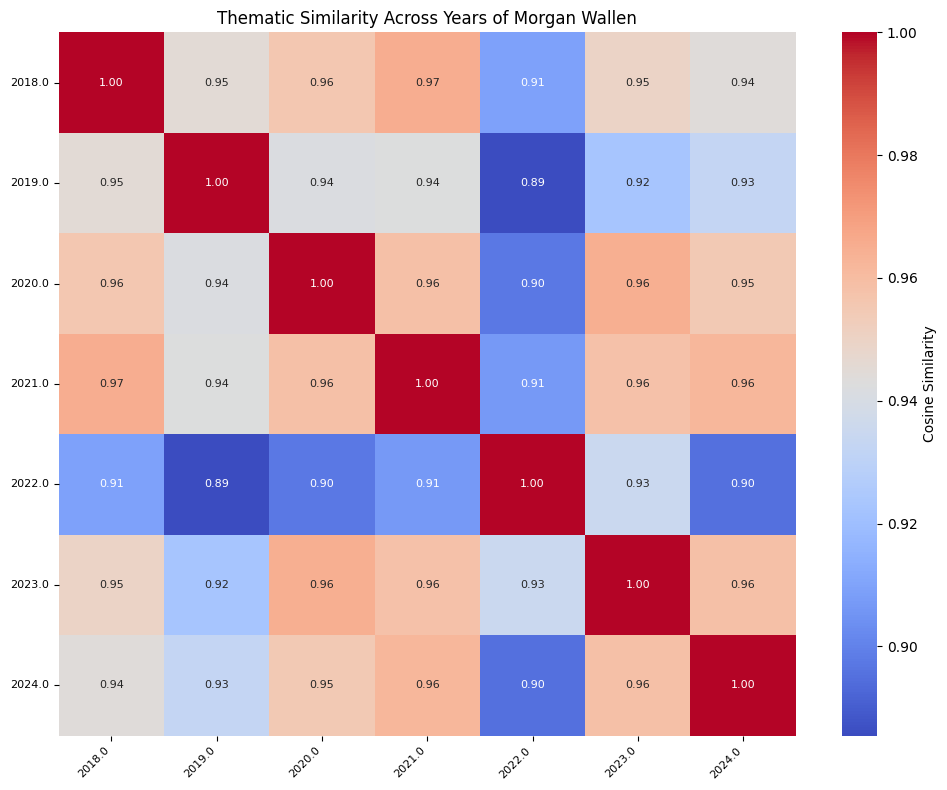

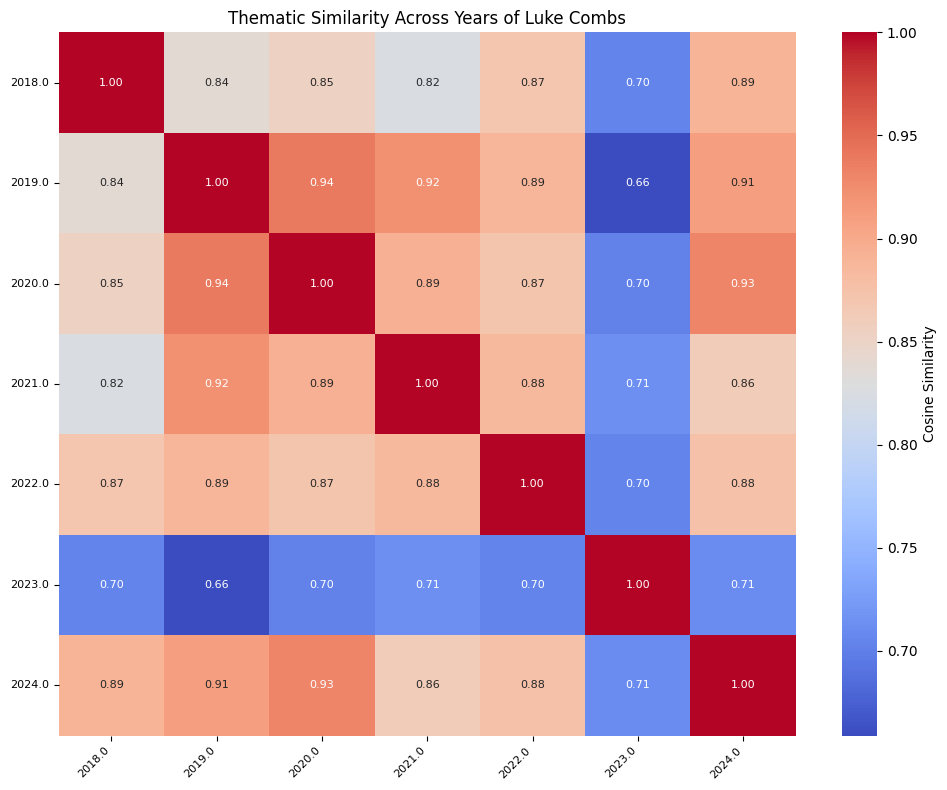

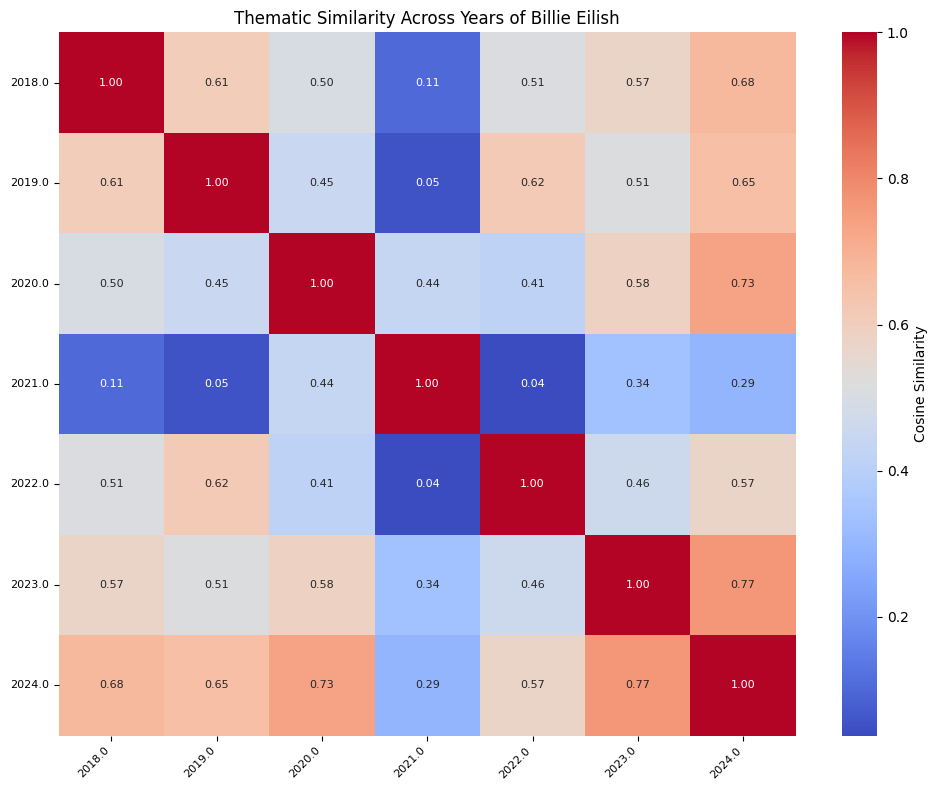

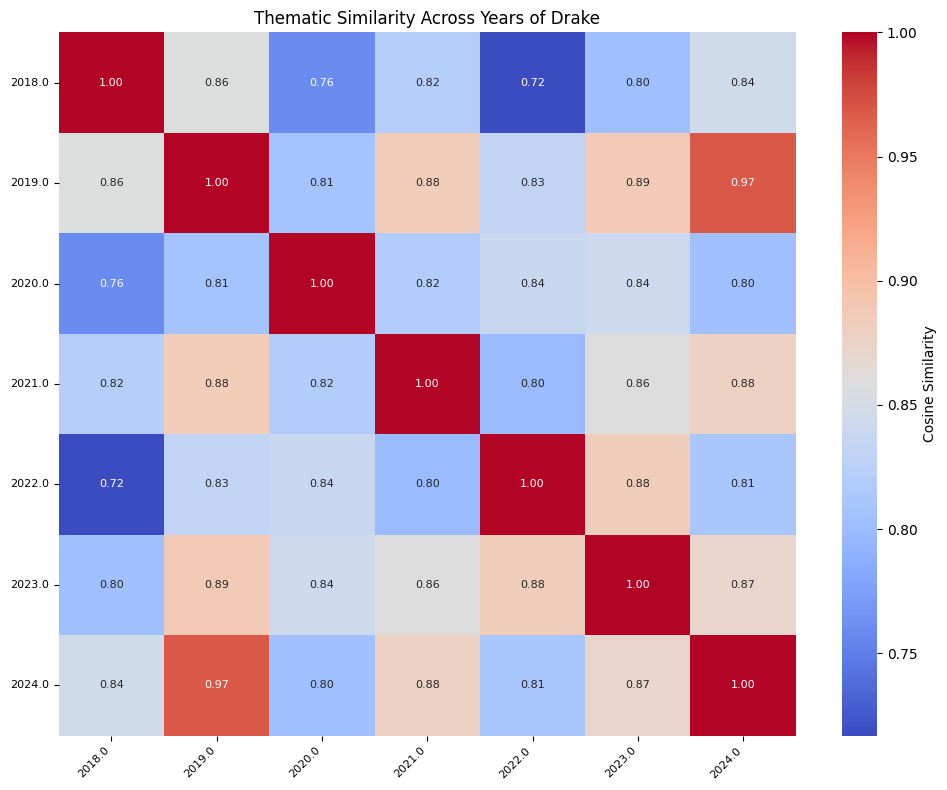

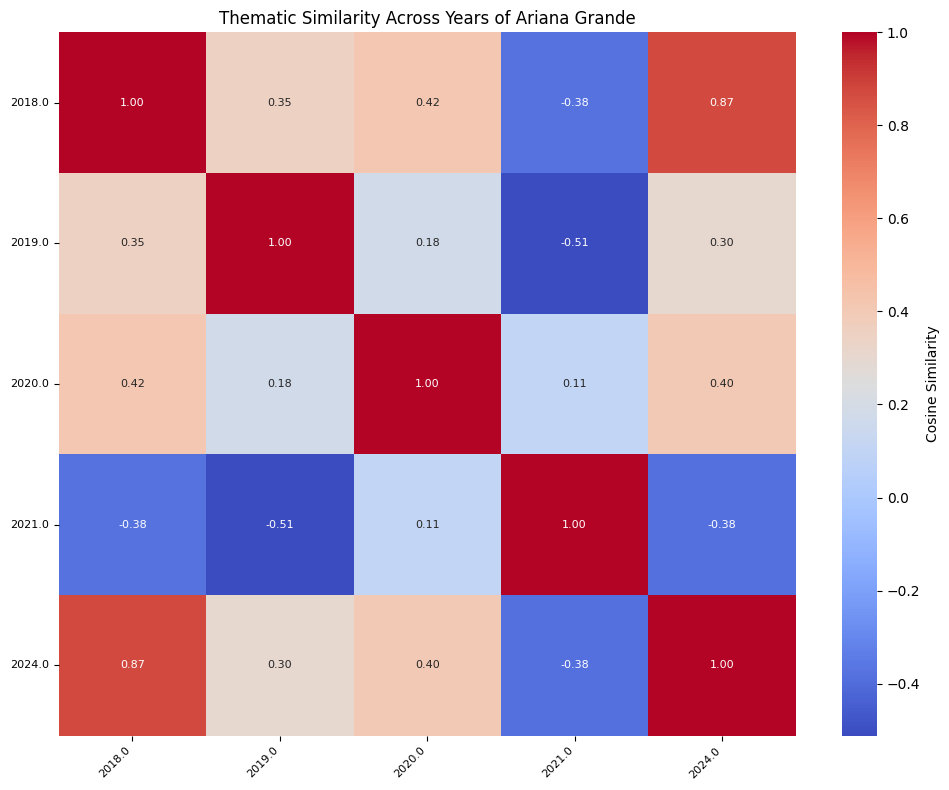

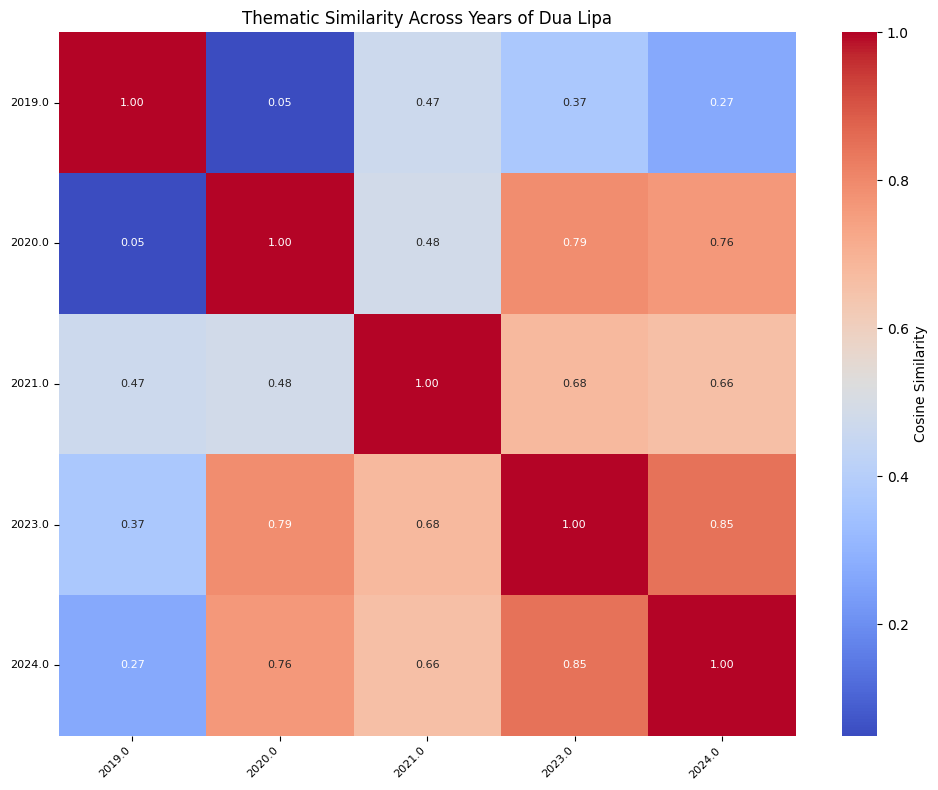

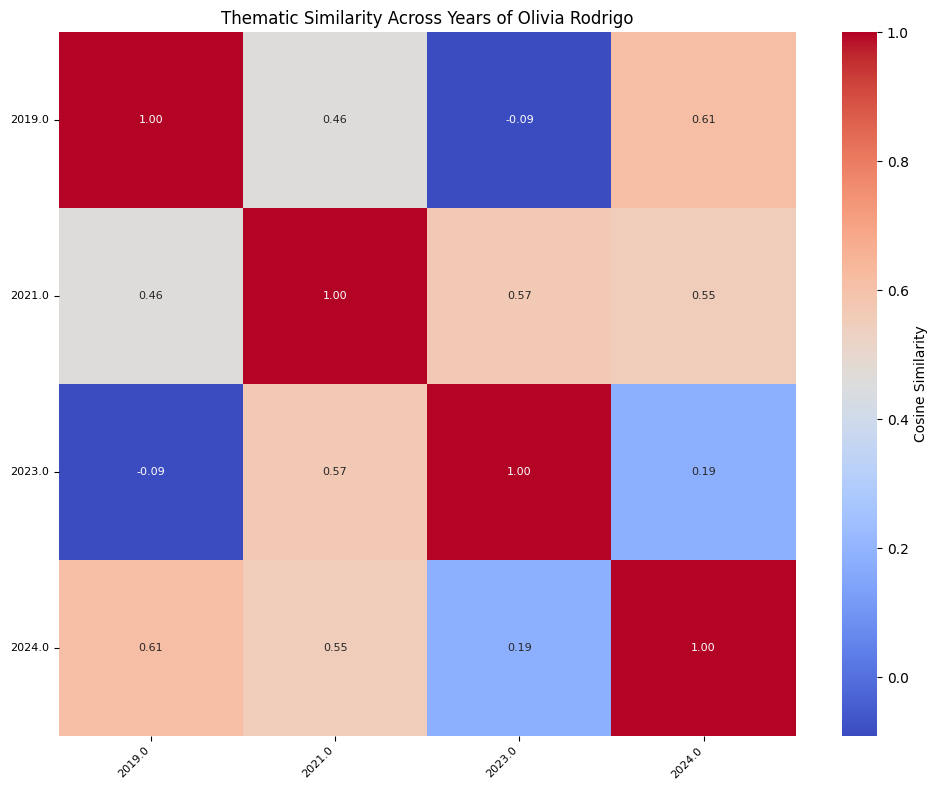

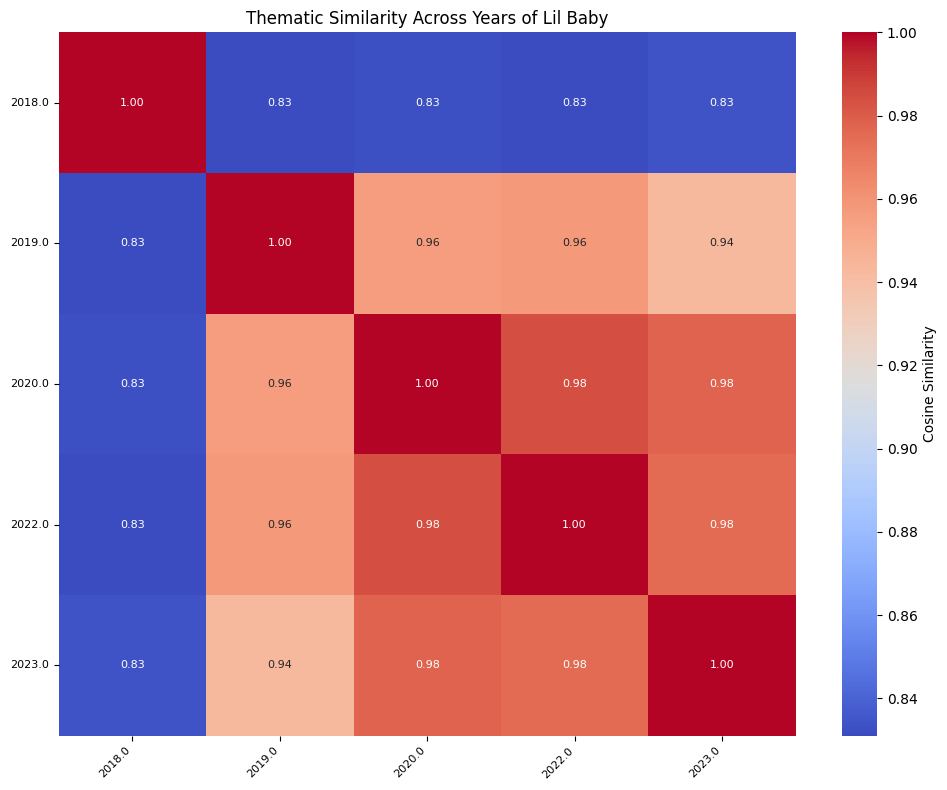

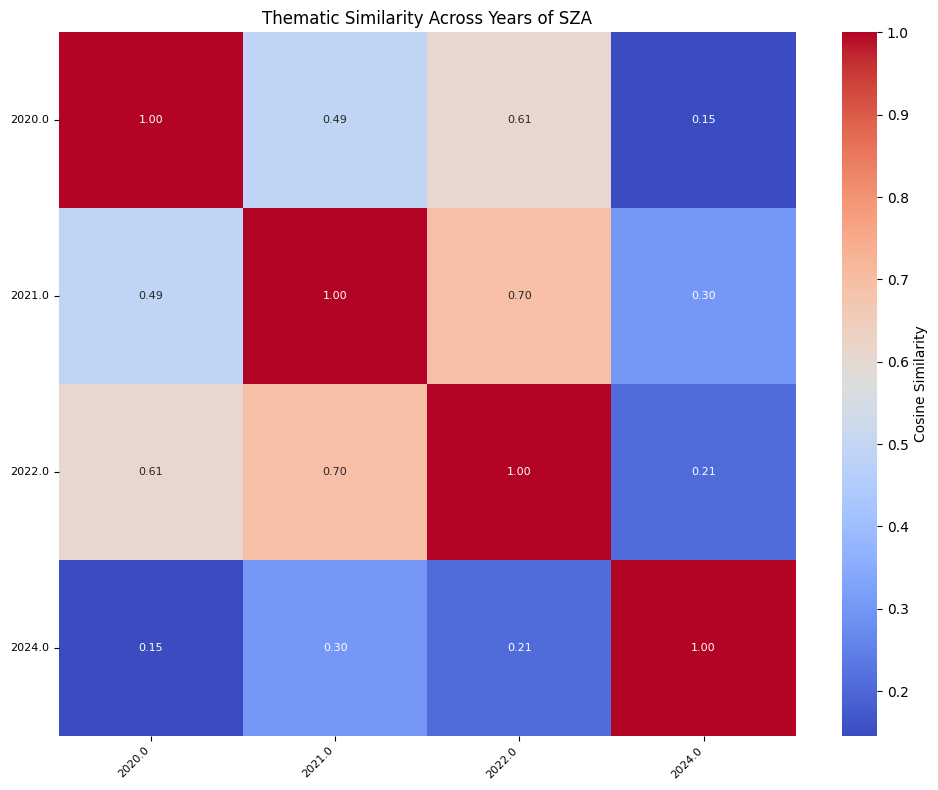

In [21]:
# Retrieve the top 10 artists
top_artists = df_dis["artist"].value_counts().head(10).index.tolist()

#Create a dataframe for each arist, where song are ordered by release date
for artist in top_artists:
    df_artist = df_dis[df_dis["artist"] == artist].sort_values("release_date")

    df_artist = df_artist[df_artist["release_year"] >= 2018]

    # Compute mean embedding per year
    year_embeddings = {}
    for year in df_artist["release_year"].unique():
        df_year = df_artist[df_artist["release_year"] == year].dropna(subset=["embedding"])
        if df_year.empty:
            continue
        mean_emb = np.mean(np.stack(df_year["embedding"].values), axis=0)
        year_embeddings[year] = mean_emb

    if len(year_embeddings) < 2:
        continue  # skip if less than 2 years

    # Sort years chronologically
    years_sorted = sorted(year_embeddings.keys())
    emb_matrix = np.stack([year_embeddings[y] for y in years_sorted])

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(emb_matrix)
    df_similarity = pd.DataFrame(similarity_matrix, index=years_sorted, columns=years_sorted)

    # Plot heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(df_similarity, annot=True, fmt=".2f", cmap="coolwarm",
                cbar_kws={'label': 'Cosine Similarity'}, annot_kws={"fontsize": 8})
    plt.title(f"Thematic Similarity Across Years of {artist}")
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

Interpretation: Each heatmap shows how thematically similar an artist’s most popular songs (entered the top 100 for at least one week) released during a year are to one another in the embedding space. Darker/redder cells (higher cosine similarity, close to 1) indicate years that are more similar in lyrical content or themes, while lighter/bluer cells (lower values) indicate years that diverge more strongly. The diagonal is always 1, since an year is perfectly similar to itself. Each year’s mean embedding is compared with all other years, with years arranged chronologically on both axes. High similarity values along the diagonal indicate consistent themes across consecutive years, while lower off-diagonal values highlight years of stylistic transition or experimentation.

Limitation:
This analysis only includes an artist’s most popular songs that entered the Top 100. As a result, it may not capture other tracks the artist released to explore certain themes, meaning some aspects of their full thematic expression could be missed. Less popular tracks that did not chart could contain themes that are absent from the embeddings, potentially biasing measures of similarity and coherence toward the artist’s most commercially successful content.

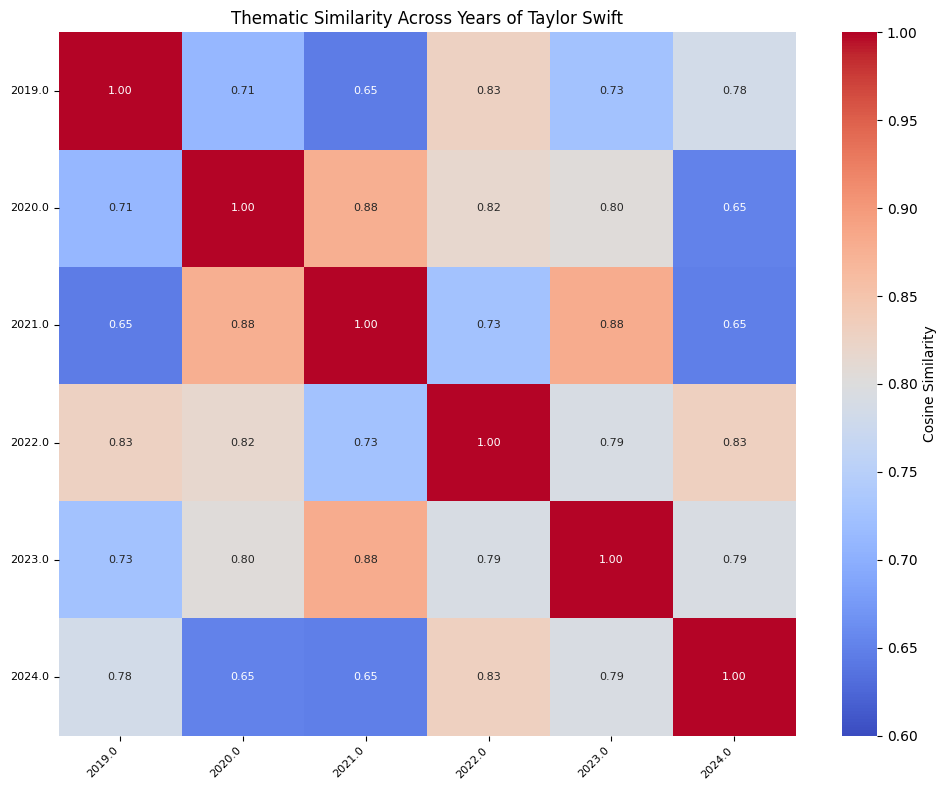

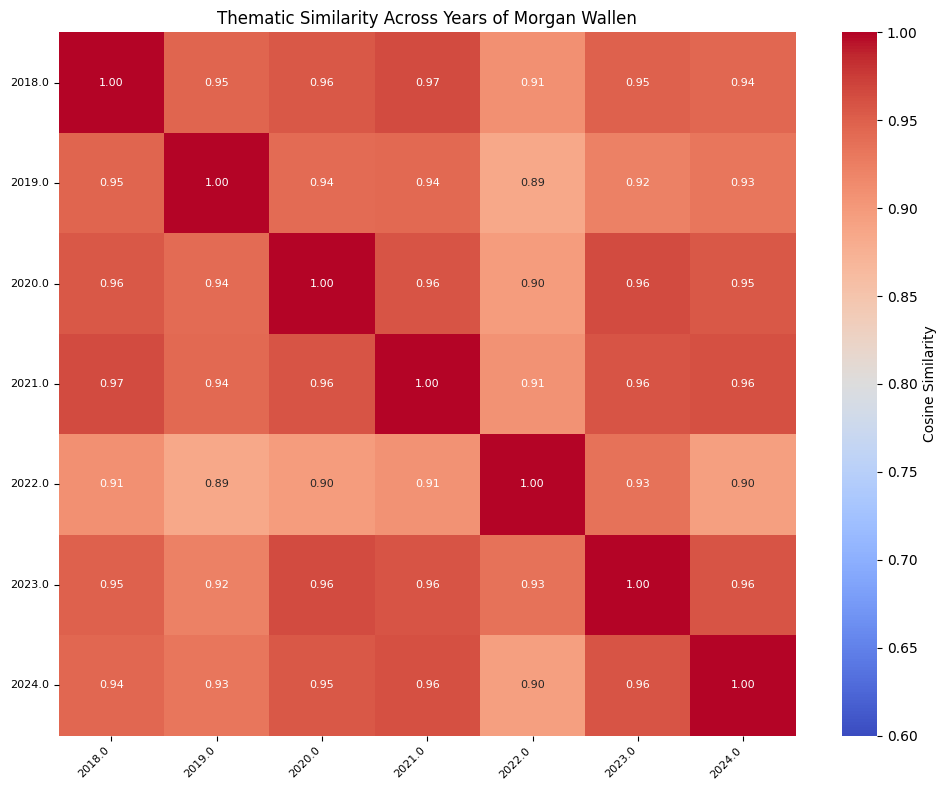

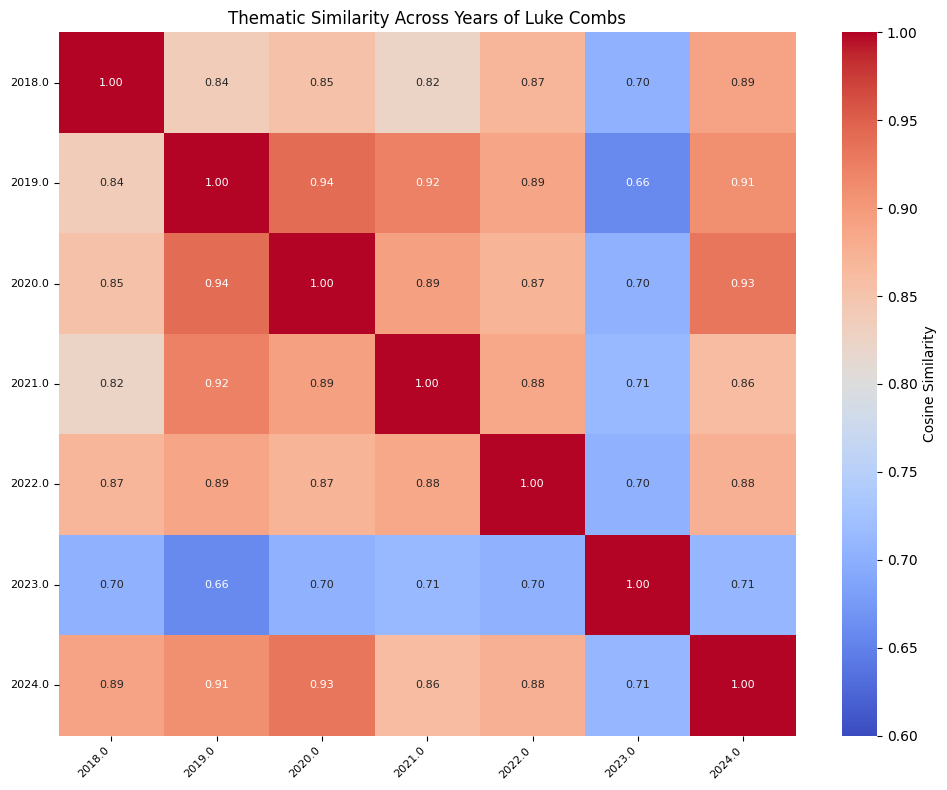

In [23]:
# Retrieve the top 3 artists
top_artists = df_dis["artist"].value_counts().head(3).index.tolist()

#Create a dataframe for each arist, where song are ordered by release date
for artist in top_artists:
    df_artist = df_dis[df_dis["artist"] == artist].sort_values("release_date")

    df_artist = df_artist[df_artist["release_year"] >= 2018]

    # Compute mean embedding per year
    year_embeddings = {}
    for year in df_artist["release_year"].unique():
        df_year = df_artist[df_artist["release_year"] == year].dropna(subset=["embedding"])
        if df_year.empty:
            continue
        mean_emb = np.mean(np.stack(df_year["embedding"].values), axis=0)
        year_embeddings[year] = mean_emb

    if len(year_embeddings) < 2:
        continue  # skip if less than 2 years

    # Sort years chronologically
    years_sorted = sorted(year_embeddings.keys())
    emb_matrix = np.stack([year_embeddings[y] for y in years_sorted])

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(emb_matrix)
    df_similarity = pd.DataFrame(similarity_matrix, index=years_sorted, columns=years_sorted)

    # Plot heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(
        df_similarity, annot=True, fmt=".2f", cmap="coolwarm",
        vmin=0.6, vmax=1,
        cbar_kws={'label': 'Cosine Similarity'}, annot_kws={"fontsize": 8}
    )
    plt.title(f"Thematic Similarity Across Years of {artist}")
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

Analysis of thematic stability over time - comparing genres:

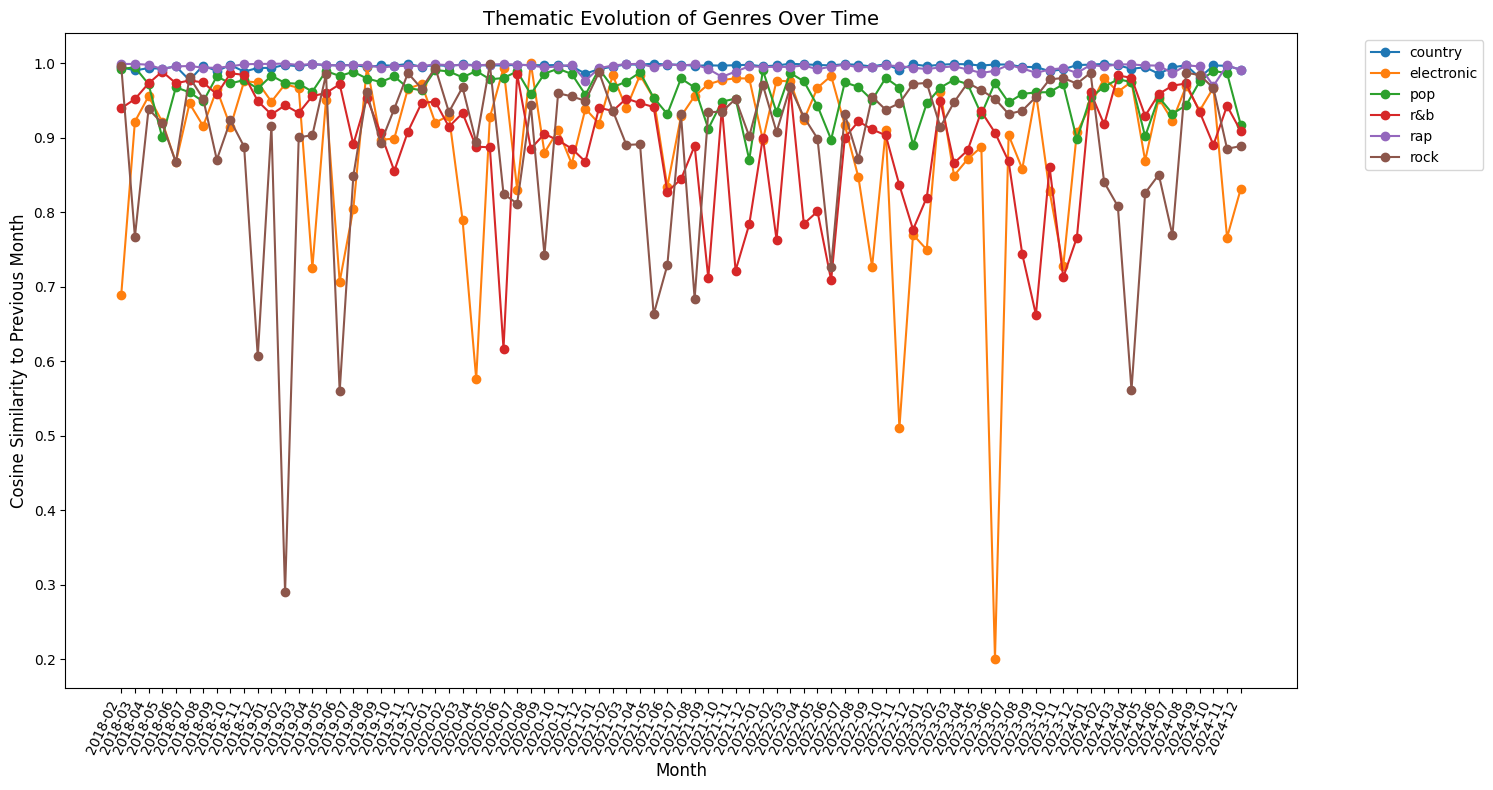

In [64]:
# Group by genre and month and compute the mean embedding by genre and month
genre_month_embeddings = (
    df_dis.dropna(subset=["embedding"])
    .groupby(["primary_tag", "month"])["embedding"]
    .apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)

# Compute cosine similarity between consecutive months by genre
results = []

for genre, group in genre_month_embeddings.groupby("primary_tag"):
    group = group.sort_values("month")
    embeddings = np.stack(group["embedding"].values)
    months = group["month"].astype(str).tolist()

    # compute similarity to previous month
    sims = [
        cosine_similarity([embeddings[i]], [embeddings[i-1]])[0,0]
        for i in range(1, len(embeddings))
    ]

    results.append(pd.DataFrame({
        "genre": genre,
        "month": months[1:],
        "similarity_to_prev": sims
    }))

df_genre_month = pd.concat(results)

# Visualization
plt.figure(figsize=(15, 8))
for genre in df_genre_month["genre"].unique():
    subset = df_genre_month[df_genre_month["genre"] == genre]
    plt.plot(subset["month"], subset["similarity_to_prev"], marker="o", label=genre)

plt.xticks(rotation=65, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Cosine Similarity to Previous Month", fontsize=12)
plt.title("Thematic Evolution of Genres Over Time", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


Interpreation: Each point in this plot represents the mean embedding of all songs in a given genre for that month. By comparing consecutive months, we can see how much the “center of gravity” of the genre’s themes shifts over time. This provides insight into directional changes in thematic content across months. However, a limitation is that a genre may appear “stable” even if it contains highly diverse sub-trends, as long as the mean embedding remains similar.

For a more detailed analysis the mean emebedding of each genre per month and the thematic diversity per genre and month (represented by mean centroid distance and mean pairwise distance) was computed:

In [51]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Define a function that retruns the necessary distance measurements in a clean manner
def compute_genre_month_metrics(df, genre_col="primary_tag", month_col="month", emb_col="embedding"):
    """
    Computes mean embedding, similarity to previous month, and diversity metrics for each genre/month and returns a DataFrame.
    """

    # Compute mean embedding and diversity metrics per genre/month
    rows = []
    for (genre, month), group in df.groupby([genre_col, month_col]):
        embeddings = np.stack(group[emb_col].values)
        mean_emb = np.mean(embeddings, axis=0)

        # Diversity: distance to centroid
        centroid_distances = np.linalg.norm(embeddings - mean_emb, axis=1)
        mean_centroid_distance = np.mean(centroid_distances)

        # Diversity: mean pairwise cosine distance
        if len(embeddings) > 1:
            dist_matrix = cosine_distances(embeddings)
            # take upper triangle only, excluding diagonal
            i_upper = np.triu_indices_from(dist_matrix, k=1)
            mean_pairwise_distance = np.mean(dist_matrix[i_upper])
        else:
            mean_pairwise_distance = 0.0

        rows.append({
            "genre": genre,
            "month": month,
            "mean_embedding": mean_emb,
            "mean_centroid_distance": mean_centroid_distance,
            "mean_pairwise_distance": mean_pairwise_distance})

    genre_month_stats = pd.DataFrame(rows)

    # Compute similarity to previous month per genre
    results = []
    for genre, group in genre_month_stats.groupby("genre"):
        group = group.sort_values("month").reset_index(drop=True)
        embeddings = np.stack(group["mean_embedding"].values)
        months = group["month"].tolist()

        sims = [None]  # first month has no previous month
        for i in range(1, len(embeddings)):
            sim = cosine_similarity([embeddings[i]], [embeddings[i-1]])[0,0]
            sims.append(sim)

        group["similarity_to_prev"] = sims
        results.append(group)

    return pd.concat(results).reset_index(drop=True)

# Apply function
df_genre_month_metrics = compute_genre_month_metrics(df_dis)
df_genre_month_metrics.head()

,genre,month,mean_embedding,mean_centroid_distance,mean_pairwise_distance,similarity_to_prev
0,country,2018-01,"[-0.0028302714, 0.016391218, 0.021263042, 0.06...",0.684700,0.544523,NaN
1,country,2018-02,"[-0.002300215, 0.020471971, 0.022602994, 0.060...",0.691467,0.546640,0.994525
2,country,2018-03,"[-0.0029836856, 0.021226102, 0.011217989, 0.06...",0.606696,0.445873,0.990169
3,country,2018-04,"[-0.002641727, 0.016295472, 0.007941898, 0.067...",0.497432,0.323017,0.993352
4,country,2018-05,"[-0.010415137, 0.012624792, 0.017441612, 0.070...",0.449741,0.233821,0.992361


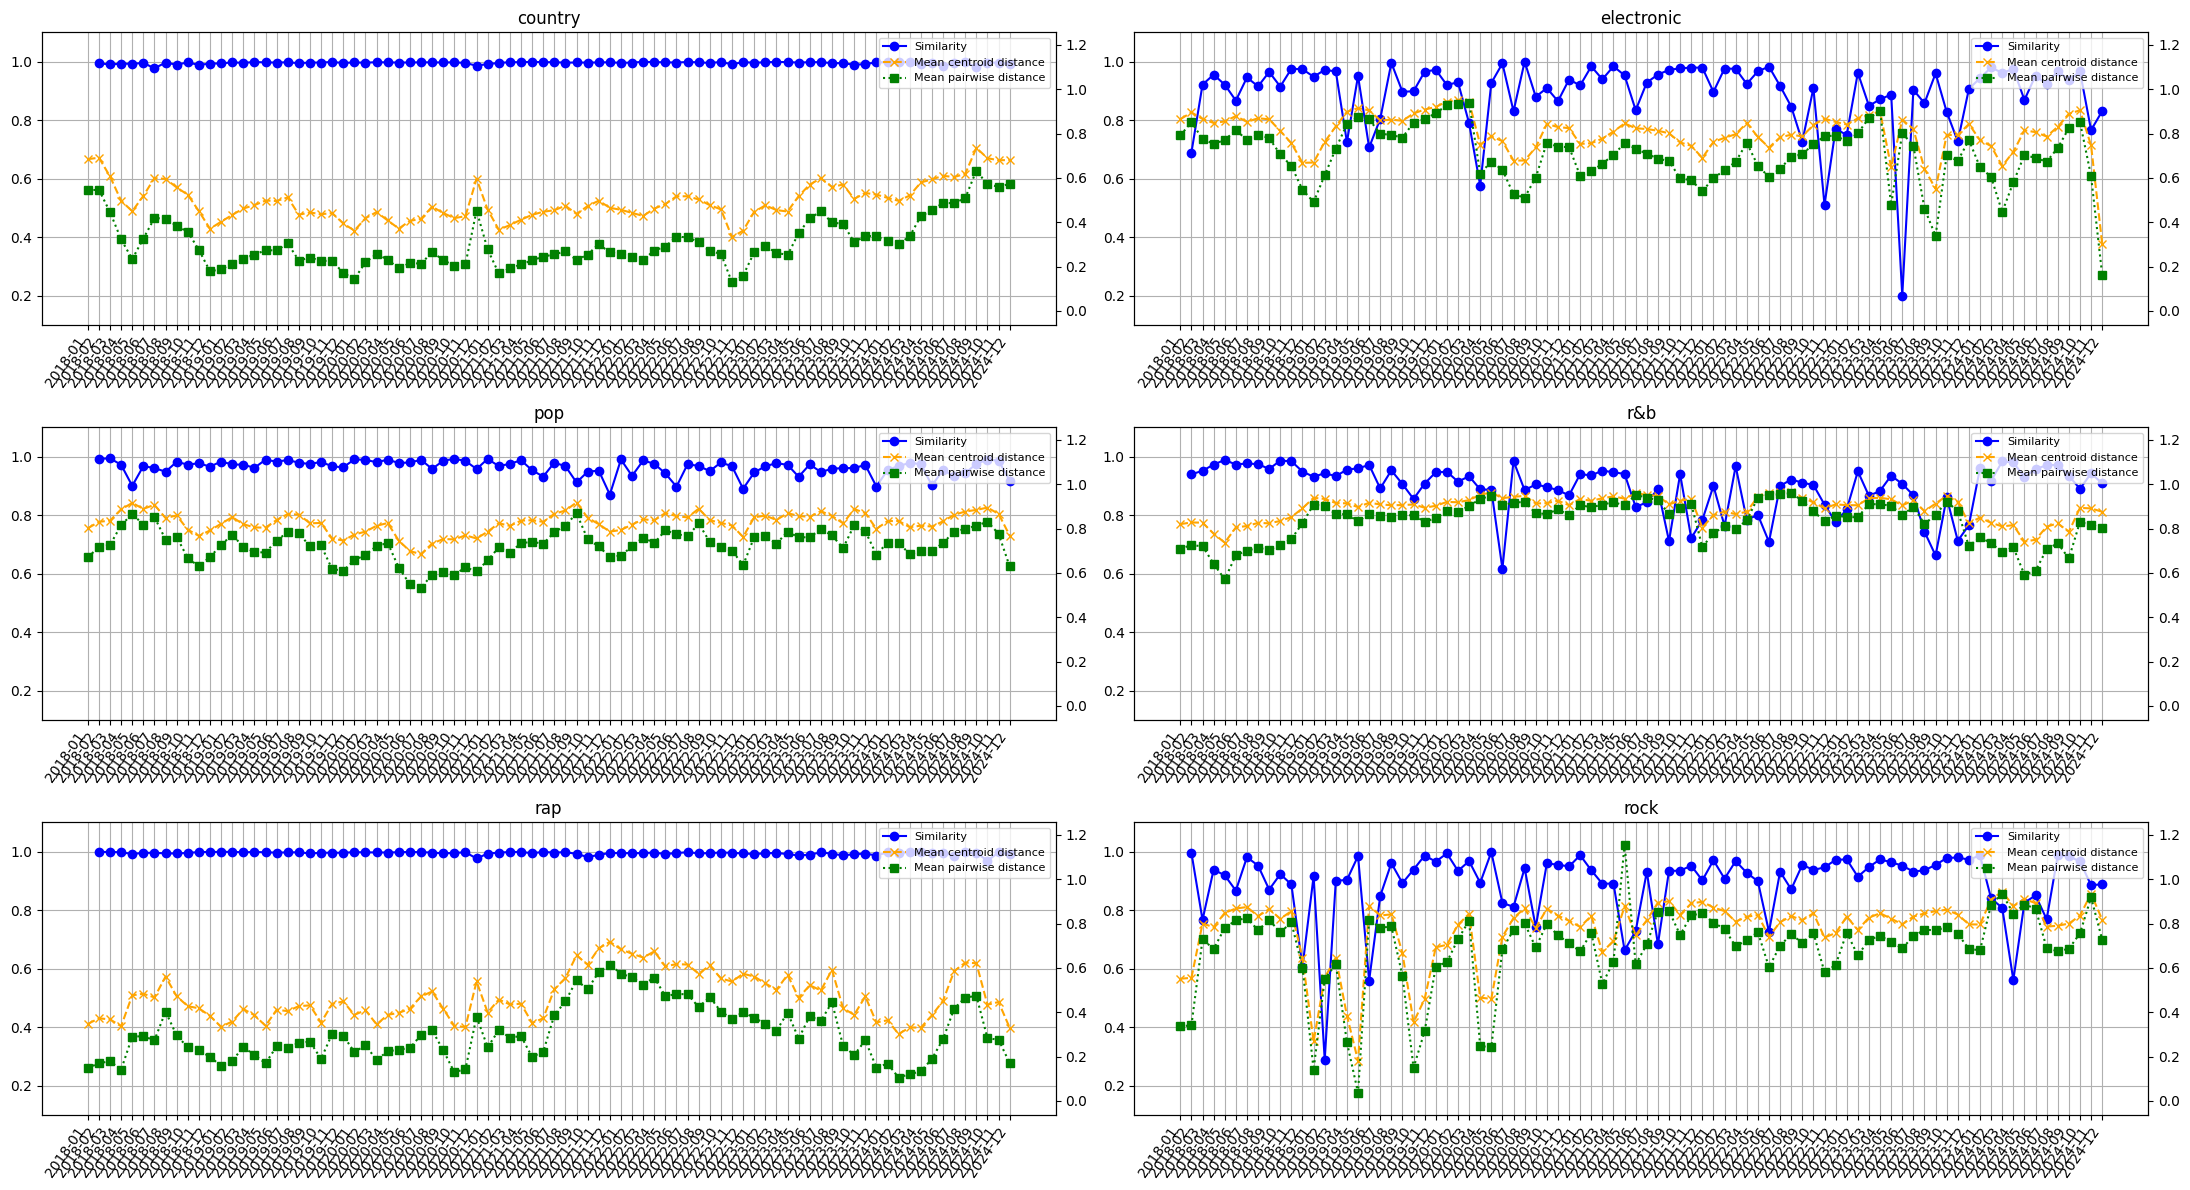

In [67]:
# Visualization of thematic stability/ diversity over time per genre
genres = df_genre_month_metrics["genre"].unique()
n_genres = len(genres)

# Determine subplot grid size
ncols = 2
nrows = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 4*nrows), sharex=False)
axes = axes.flatten()

# Compute global min/max for each axis
sim_min = df_genre_month_metrics["similarity_to_prev"].min()-0.1
sim_max = df_genre_month_metrics["similarity_to_prev"].max()+0.1
div_min = min(df_genre_month_metrics["mean_centroid_distance"].min(),
              df_genre_month_metrics["mean_pairwise_distance"].min())-0.1
div_max = max(df_genre_month_metrics["mean_centroid_distance"].max(),
              df_genre_month_metrics["mean_pairwise_distance"].max())+0.1

for i, genre in enumerate(genres):
    ax = axes[i]
    subset = df_genre_month_metrics[df_genre_month_metrics["genre"] == genre].sort_values("month")

    # Primary y-axis
    ax.plot(subset["month"], subset["similarity_to_prev"], marker="o", color="blue", label="Similarity")
    ax.set_ylim(sim_min, sim_max)

    # Secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(subset["month"], subset["mean_centroid_distance"], marker="x", linestyle="--", color="orange", label="Mean centroid distance")
    ax2.plot(subset["month"], subset["mean_pairwise_distance"], marker="s", linestyle=":", color="green", label="Mean pairwise distance")
    ax2.set_ylim(div_min, div_max)

    ax.set_title(genre)
    ax.set_xticks(subset["month"])
    ax.set_xticklabels(subset["month"].astype(str), rotation=55, ha="right")
    ax.grid(True)

    # Merge legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, fontsize=8)

plt.tight_layout()
plt.show()

Interpretation:


*   Similarity to perv month: Distance between mean embeddings (of all popular songs of a genre between two consecutive months)
*   Mean Centroid distance: Spread around the “average theme” (mean distance between emebedding of a song and the mean embedding of the month/genre (mean of emebeddings of all popular songs per genre and month))
*   Mean Pairwise distance: Average difference between all songs (mean distance between all pairs of sonsg per genre and month)





